In [1]:
import desitarget 
from desitarget.targets import desi_mask, bgs_mask, mws_mask

import astropy
from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
import astropy.units as U

import numpy as np
import matplotlib.pyplot as plt
import glob
import os

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['font.size'] = 15

In [2]:
! ls 

 da02_bright_cat.ipynb		  da02_clustering_plots.ipynb
 da02_bright_k+e_vol_bins.ipynb  'OLD clustering_main_cat.ipynb'
 da02_bright_weights.ipynb


In [3]:
N = Table.read('/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/test/BGS_BRIGHT_N_clustering.dat.fits')
S = Table.read('/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/test/BGS_BRIGHT_S_clustering.dat.fits')
N['APPLIM'] = 19.539993
S['APPLIM'] = 19.5
N['ZLIM_UPPER'] = 0.6
S['ZLIM_UPPER'] = 0.6
N8 = Table.read('/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/test/BGS_BRIGHT_N_6_clustering.ran.fits')
S8 = Table.read('/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/test/BGS_BRIGHT_S_6_clustering.ran.fits')
N8['APPLIM'] = 19.539993
S8['APPLIM'] = 19.5
N8['ZLIM_UPPER'] = 0.6
S8['ZLIM_UPPER'] = 0.6

In [4]:
data = Table(np.hstack((N, S)))

data

TARGETID,Z,NTILE,TILES,RA,DEC,WEIGHT,WEIGHT_ZFAIL,WEIGHT_COMP,WEIGHT_SYS,flux_g_dered,flux_r_dered,flux_z_dered,flux_w1_dered,flux_w2_dered,NZ,WEIGHT_FKP,REST_GMR_0P1,KCORR_R0P1,KCORR_G0P1,KCORR_R0P0,KCORR_G0P0,REST_GMR_0P0,EQ_ALL_0P0,EQ_ALL_0P1,ABSMAG_RP1,ABSMAG_RP0,APPLIM,ZLIM_UPPER
int64,float64,int64,bytes11,float64,float64,float64,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633366047264297,0.16095951646742163,1,20001,268.7008850398322,58.31651750837625,2.368794267525197,1.0202607,2.0,1.1608769635685512,7.7169294,16.809292,28.698618,21.945616,12.552565,0.01856145426373512,0.016762400045732102,0.721548822097457,-0.0480892836645471,0.07562442170381622,0.17676402087349832,0.38471493423821956,0.637311614101099,-0.15613073097339897,-0.15613073097339897,-19.01505339080518,-19.239906695343226,19.539993,0.6
39633366047264412,0.2262081883049673,1,20001,268.7121644210125,58.17137871856034,7.885935437241774,1.0119702,7.0,1.1132365826456456,5.6451545,17.743734,36.715954,42.338474,30.138641,0.008661962234134126,0.03524444880947024,0.8916872718248806,0.055141909042679765,0.4068761917832286,0.28235492619244257,0.7782674152354703,0.7475090655224019,-0.21942194265581827,-0.21942194265581827,-19.934640009395764,-20.16185302654553,19.539993,0.6
39633366047264710,0.20509598282456507,1,20001,268.7447179685751,58.35164090788789,3.5493453409436366,1.0191563,3.0,1.1608769635685512,9.199382,18.115196,31.323214,38.144897,31.80481,0.011911149469520776,0.025879084952906813,0.5397214238839109,-0.06256931584764004,0.13341940431141774,0.14342391928728798,0.37673369579311694,0.5024003675371398,-0.19894310333982812,-0.19894310333982812,-19.621429255164735,-19.82742249029966,19.539993,0.6
39633378638561503,0.3053206447975358,1,20001,270.5073482253405,59.33896919077583,2.3158908743540527,1.0118785,2.0,1.1443522597899662,5.816003,24.00663,49.666294,60.648766,39.263374,0.0032132398416806277,0.08965087986982612,0.948196974030458,0.1920467162085221,0.783116328481775,0.4201382412002311,1.1720507422145277,0.7873540852894143,-0.2961610254536097,-0.2961610254536097,-21.06440409622748,-21.29249562121919,19.539993,0.6
39633372376467396,0.2775320962351793,1,20001,268.5121713053863,58.81550252397294,3.2715555825991145,1.0216688,3.0,1.067389487000734,4.9087415,18.647816,47.224636,121.78173,128.69661,0.006279602345083299,0.047974048180681544,0.9314978452803849,0.14147467853484277,0.6591231040064112,0.36796505192895507,1.0449898286507322,0.7721214940301759,-0.26920613334812393,-0.26920613334812393,-20.528724008118733,-20.755214381512847,19.539993,0.6
39633366047264487,0.10750217420934505,1,20001,268.72025843577376,58.150995263304566,3.3792646040688217,1.0118438,3.0,1.1132365826456456,65.581665,164.53503,310.0892,251.75818,156.65999,0.026715267796619462,0.011706208574030397,0.9793147837596916,-0.09317160654032018,-0.07379673881075391,0.1383131834916128,0.320207896877415,0.8167949381034556,-0.10427710898306469,-0.10427710898306469,-20.549183985528458,-20.78066877556039,19.539993,0.6
39633366047264069,0.23373774756268273,1,20001,268.6773406567538,58.196956322063585,5.65722136226266,1.0163556,5.0,1.1132365826456456,5.1988206,18.016794,36.307766,35.975773,23.484913,0.008661962234134126,0.03524444880947024,0.9539436956606155,0.08093321342091594,0.4764215093374489,0.30965139400867076,0.8662922728465651,0.7927911127392542,-0.22672561513580225,-0.22672561513580225,-20.049808198242104,-20.27852637882986,19.539993,0.6
39633366051455429,0.2274295421540546,1,20001,268.86868202000977,58.30892044280674,2.274872090138421,1.0217379,2.0,1.1132365826456456,24.459436,80.40709,158.21242,162.85123,116.77073,0.008661962234134126,0.03524444880947024,0.922871669122532,0.06516651677486968,0.43441482751073607,0.2918134730009922,0.8171449928840472,0.7667884599753434,-0.22060665588943296,-0.22060665588943296,-21.597261119229156,-21.82390807545528,19.539993,0.6
39633366

In [5]:
ran = Table(np.hstack((N8,S8)))
ran

TARGETID,RA,DEC,NTILE,TILES,Z,WEIGHT,WEIGHT_SYS,WEIGHT_COMP,WEIGHT_ZFAIL,flux_g_dered,flux_r_dered,flux_z_dered,flux_w1_dered,flux_w2_dered,REST_GMR_0P1,KCORR_R0P1,KCORR_G0P1,KCORR_R0P0,KCORR_G0P0,REST_GMR_0P0,EQ_ALL_0P0,EQ_ALL_0P1,ABSMAG_RP0,ABSMAG_RP1,NZ,WEIGHT_FKP,APPLIM,ZLIM_UPPER
int64,float64,float64,int64,bytes11,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
327863306729553930,184.4984440421149,32.54742271150323,1,21175,0.16343709104341408,2.2001674776473172,1.086026744873662,2.0,1.0129435,14.355097,26.690342,41.080173,36.094505,26.842234,0.5651025171126373,-0.07061676130173142,0.03765108291375638,0.1396809440760883,0.2897338403621438,0.5233174650420696,-0.15853397831211166,-0.15853397831211166,-19.738850847812188,-19.52855314243437,0.01856145426373512,0.016762400045732102,19.539993,0.6
327863306729553971,184.51647351004667,32.5255703901821,1,21175,0.18156818128596314,2.3483692585593627,1.161728665237873,2.0,1.0107219,13.623394,25.633204,39.63821,32.122196,24.620485,0.541816009061721,-0.06905540667791253,0.07542313992442898,0.13729305663760788,0.3194610526733622,0.5041265596283082,-0.17612113584738423,-0.17612113584738423,-19.926877566066416,-19.7205291027509,0.014402743714152611,0.02149839471533367,19.539993,0.6
327863306729554002,184.6405875703038,32.52180461359298,1,21175,0.1947388192404967,0.9117784997629556,0.9022279241243757,1.0,1.0105855,14.206396,24.307629,34.608627,24.996632,21.190147,0.4193718688794277,-0.09976387548606884,0.06400939723606602,0.0861472596038571,0.2668355616569639,0.4024568395484557,-0.18889665466328182,-0.18889665466328182,-19.97402734768387,-19.78811621259394,0.014402743714152611,0.02149839471533367,19.539993,0.6
327863306729554012,184.59069124193948,32.591669077399644,1,21175,0.4780629203702279,1.0323991243848119,1.0207895195360295,1.0,1.0113732,19.469648,37.865414,73.2695,113.222496,141.6192,0.2307650344636037,-0.16207563886145465,0.3293692570948632,0.0026301641998401626,0.4802933434671688,0.24454675115259328,-0.4637210327591211,-0.4637210327591211,-22.343483526122128,-22.178777723060833,0.00018912032870157744,0.6259184739112926,19.539993,0.6
327863306729554098,184.6345217534163,32.57348052867995,1,21175,0.2981841364534467,3.4769996639664322,1.1430985070934643,3.0,1.0139108,18.746927,41.207504,77.84458,147.70078,180.22148,0.4583143572173571,-0.07679581473148918,0.320005718554139,0.11539130524246229,0.5351961192687655,0.4353110764766264,-0.28923861235984333,-0.28923861235984333,-21.522175670769062,-21.32998855079511,0.004818432414870184,0.061625459045850824,19.539993,0.6
327863306729554191,184.60390730626236,32.600554034312225,1,21175,0.3404507815474048,2.317567822004746,1.146630075727983,2.0,1.0105996,3.738005,18.184706,41.64117,58.626637,38.220894,1.0436987695353714,0.2898893985069941,0.9638553475995519,0.5283949888453718,1.3683504741383796,0.8777092333349219,-0.33023725810098264,-0.33023725810098264,-21.338723028204843,-21.100217437866466,0.0019378205018065772,0.14037373422840843,19.539993,0.6
327863306729554203,184.66497208870518,32.520248755032156,1,21175,0.49372241690224183,1.2280863487355589,1.2150876780218949,1.0,1.0106977,4.5241637,16.023176,38.95374,57.836548,37.919502,0.7549428354723242,0.4733658762869695,1.0914489349796843,0.7004964815504708,1.4129129885463927,0.6606093871691172,-0.47891074439517456,-0.47891074439517456,-22.17591684801171,-21.94878624274821,0.00012615723321793355,0.7149607654878182,19.539993,0.6
327863306729554223,184.6979306929221,32.54532782603554,1,21175,0.15138485646107958,1.081963305413742,1.0706265645359385,1.0,1.0105889,13.659486,33.053143,56.71492,40.301365,21.665638,0.8380645244459882,-0.04412212473693467,0.07725930418621765,0.18406425552194014,0.42915278931842993,0.7143574195726509,-0.1468433107672472,-0.1468433107672472,-19.844821100569195,-19.616634720310323,0.01866714443859982,0.016669076200062905,19.539993

In [6]:
redshift_cut = np.where(data['Z'] <= 0.6)[0]
def zmax(m):
    return 10**(-(m+22.8)/5)

M_range = np.arange(-23,-12,0.1)
zmax_range = np.clip(zmax(M_range),a_min=None,a_max=0.6)

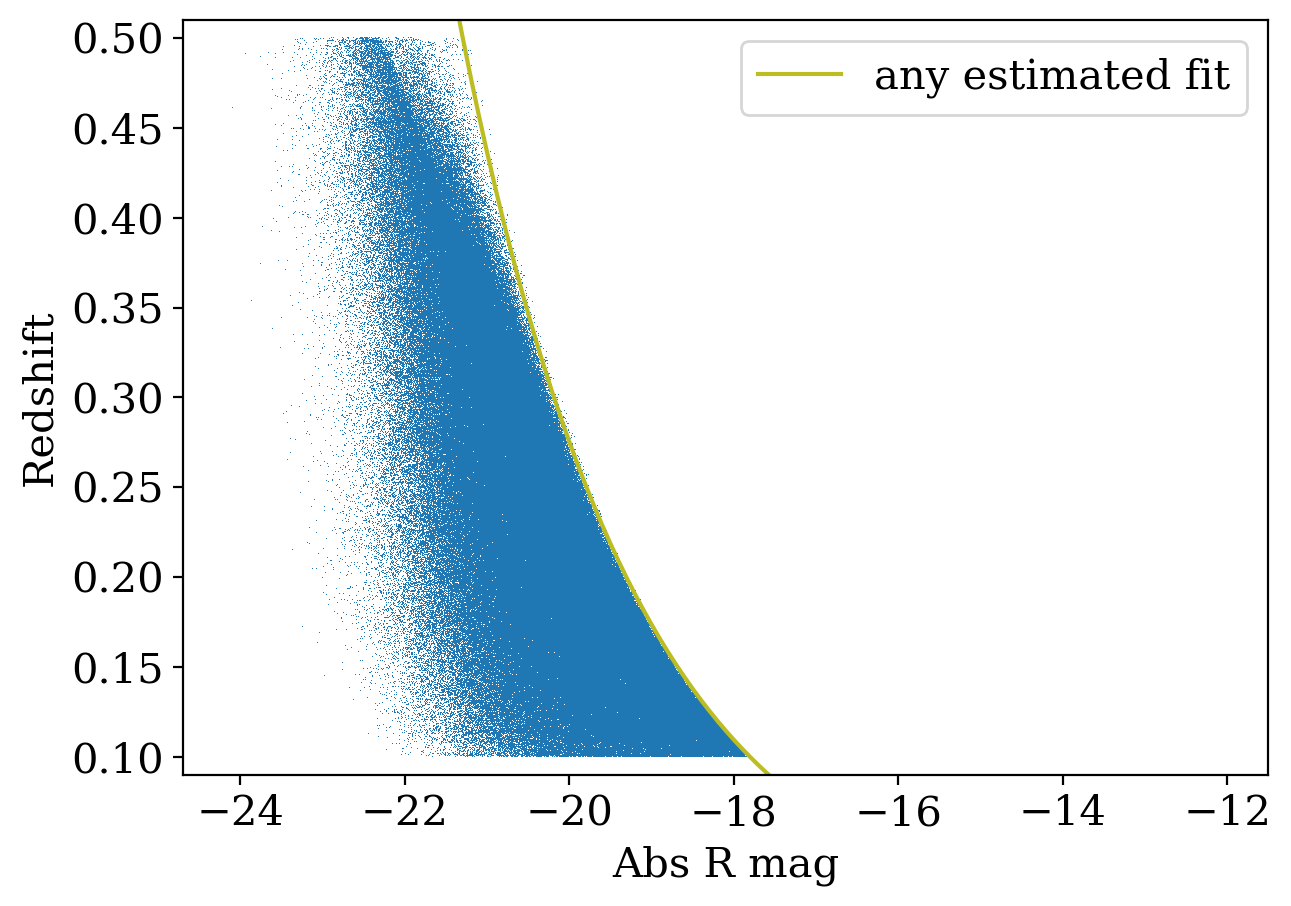

In [7]:
fig, ax1 = plt.subplots(figsize=(7,5),dpi=200)
ax1.plot(data['ABSMAG_RP1'][redshift_cut], data['Z'][redshift_cut], lw=0, marker=',')
#¢ax1.set_yscale('log')
ax1.plot(M_range, zmax_range, label='any estimated fit', color='tab:olive')
#ax1.scatter(data['ABSMAG_RP1P1'], zmax_clipped, color='tab:red', s=0.01)
plt.ylabel('Redshift')
plt.xlabel('Abs R mag')
plt.legend()
plt.ylim(0.09,0.51)
plt.show()

In [8]:
cosmo = FlatLambdaCDM(H0=100, Om0=0.3)
data['DL'] = cosmo.luminosity_distance(np.array(data['Z']))

In [9]:
data['ABSMAG_LIM'] = data['APPLIM'] - 5*np.log10(data['DL'])-25-data['KCORR_R0P1']-data['EQ_ALL_0P1']

In [10]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

195603 0.14999975607170113
514764 0.4700007198589736
368346 0.3230006227475963


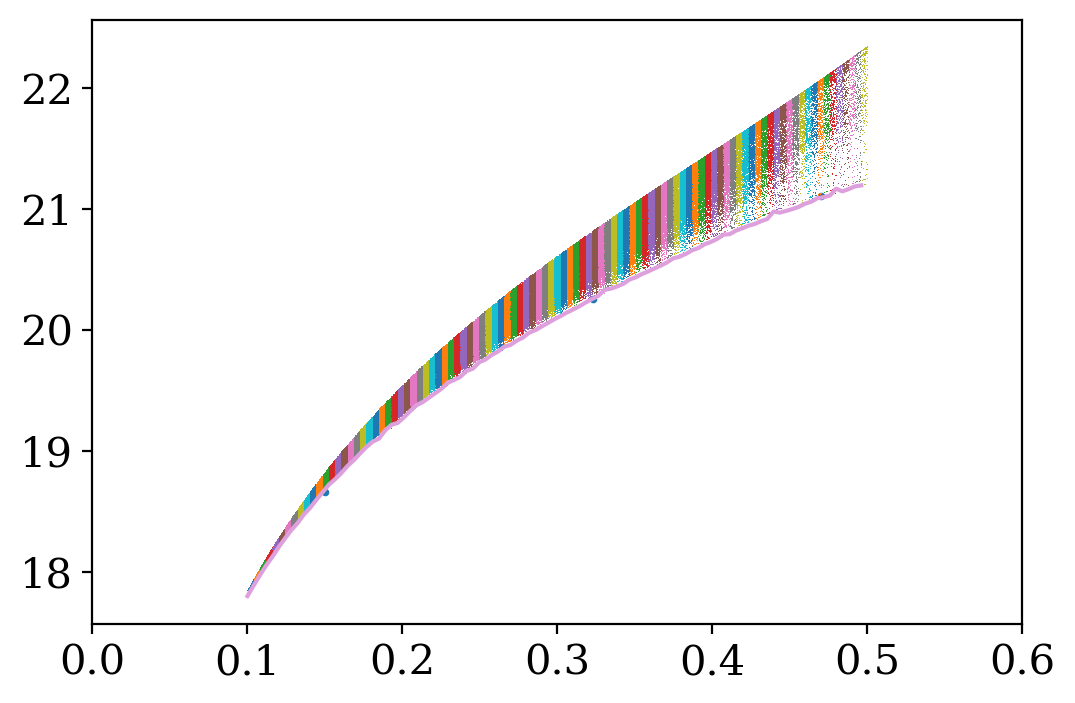

In [11]:
plt.figure(dpi=200)
def find_absmag_envelope(z_range): #obsolete
    if isinstance(z_range, np.ndarray):
        a = np.empty(len(z_range)-1)
        for i, z in enumerate(z_range):
            if i == len(z_range)-1:
                break
            z_close = np.where(np.logical_and(data['Z'] > (z), data['Z'] < (z_range[i+1])))[0]

            #plt.plot([zmid,zmid], [17,22])
            plt.plot(data['Z'][z_close], -data['ABSMAG_LIM'][z_close], lw=0, marker=',', label='absmaglim')

            try:
                absmag_min = np.amax(np.array(data['ABSMAG_LIM'][z_close]))
            except:
                absmag_min = np.nan
            a[i] = absmag_min
            #plt.scatter(z, -absmag_min, s=10)
        return a
    elif isinstance(z_range, float):
        z = z_range
        z_closest = find_nearest(data['Z'], z)
        print(z_closest, data['Z'][z_closest])
        z_close = np.where(np.logical_and(data['Z'] > (z-0.001), data['Z'] < (z+0.001)))[0]
        try:
            absmag_min = np.amax(np.array(data['ABSMAG_LIM'][z_close]))
        except:
            absmag_min = np.nan
        return absmag_min

z_range = np.linspace(0.1,0.5,100)        
absmag_env = find_absmag_envelope(z_range) 
plt.plot(z_range[0:-1], -absmag_env, color='plum')
plt.scatter(np.array((0.15,0.47,0.323)),-np.array((find_absmag_envelope(0.15),find_absmag_envelope(0.47),find_absmag_envelope(0.323))), s=3)
plt.xlim(0,0.6)
plt.show()

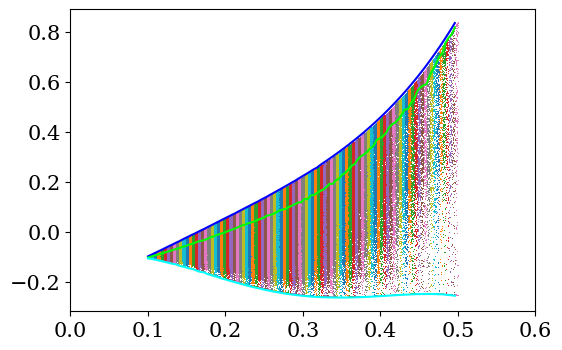

In [12]:
plt.figure(dpi=100)
def find_k(z_range, stat, cat):
    if isinstance(z_range, np.ndarray):
        k = np.empty(len(z_range)-1)
        for i, z in enumerate(z_range):
            if i == len(z_range)-1:
                break
            z_close = np.where(np.logical_and(cat['Z'] > (z), cat['Z'] < (z_range[i+1])))[0]
            plt.plot(cat['Z'][z_close], cat['KCORR_R0P1'][z_close], lw=0, marker=',')
            if stat == 'med':
                k[i] = np.median(cat['KCORR_R0P1'][z_close])
            elif stat == 'max':
                k[i] = np.amax(cat['KCORR_R0P1'][z_close])
            elif stat == 'min':
                k[i] = np.amin(cat['KCORR_R0P1'][z_close])
        return k

      
k_med = find_k(z_range, 'med', data) 
k_max = find_k(z_range, 'max', data)
k_min = find_k(z_range, 'min', data)
plt.plot(z_range[0:-1], k_max, color='blue')
plt.plot(z_range[0:-1], k_med, color='lime')
plt.plot(z_range[0:-1], k_min, color='aqua')

plt.xlim(0,0.6)
plt.show()

In [13]:
z1 = find_nearest(data['Z'], 0.2)
z2 = find_nearest(data['Z'], 0.4)
e_slope = (data['EQ_ALL_0P1'][z2] - data['EQ_ALL_0P1'][z1])/(data['Z'][z2] - data['Z'][z1])
print(data['Z'][z2], data['EQ_ALL_0P1'][z2])
print(data['Z'][z1], data['EQ_ALL_0P1'][z1])
print(e_slope)

e_intercept = data['EQ_ALL_0P1'][z2] - e_slope*data['Z'][z2]
print(e_intercept)
#y = mx+c

0.4000004507649722 -0.38800043724202304
0.1999998905457913 -0.19399989382941754
-0.9700000000000001
0.0


In [14]:
def absmag(appmag, z, k, e):
    return appmag - 5*np.log10(cosmo.luminosity_distance(z).to_value()) -25 - k - e

In [15]:
print(cosmo.luminosity_distance(0.2))

686.047520805891 Mpc


In [16]:
print(astropy.cosmology.z_at_value(cosmo.luminosity_distance,686.047520805891*U.Mpc))

0.20000000075338056 redshift


In [17]:
dl_range = cosmo.luminosity_distance(z_range[0:-1]).to_value()
e_z = e_slope*z_range[0:-1] + e_intercept

faintlim_range_N_max = absmag(19.539993, z_range[0:-1], k_max, e_z)
faintlim_range_S_max = absmag(19.5, z_range[0:-1], k_max, e_z)

faintlim_range_N_min = absmag(19.539993, z_range[0:-1], k_min, e_z)
faintlim_range_S_min = absmag(19.5, z_range[0:-1], k_min, e_z)

faintlim_range_N_med = absmag(19.539993, z_range[0:-1], k_med, e_z)
faintlim_range_S_med = absmag(19.5, z_range[0:-1], k_med, e_z)

brightlim_range_max = absmag(15, z_range[0:-1], k_max, e_z)
brightlim_range_min = absmag(15, z_range[0:-1], k_min, e_z)
brightlim_range_med = absmag(15, z_range[0:-1], k_med, e_z)

In [18]:
def absmag_lim(lim0, lim1, cat):
    return np.where(np.logical_and(cat['ABSMAG_RP1'] < lim0, cat['ABSMAG_RP1'] > lim1))

def redshift_lim(lim, cat):
    return np.where(cat['Z'] < np.minimum(zmax(lim),0.6))

def redshift_lim_bright(lim, cat):
    return np.where(cat['Z'] < np.minimum(zmax_bright(lim),0.6))

def redshift_lim_from_k(lim0, lim1, cat):
    N_i = np.where(cat['APPLIM'] == 19.539993)
    S_i = np.where(cat['APPLIM'] == 19.5)
    zlim_upper_S = z_range[find_nearest(faintlim_range_S_max,lim0)]
    zlim_upper_N =  z_range[find_nearest(faintlim_range_N_max,lim0)]
    cat['ZLIM_UPPER'][S_i] = zlim_upper_S
    cat['ZLIM_UPPER'][N_i] = zlim_upper_N

    upper_limed = np.where(cat['Z'] < np.minimum(cat['ZLIM_UPPER'],0.6))
    z_lim_lower = z_range[find_nearest(brightlim_range_min,lim1)]
    return [[zlim_upper_N, zlim_upper_S], z_lim_lower], np.intersect1d(upper_limed, np.where(cat['Z'] > z_lim_lower))

      
def find_zmax(M, lim_range):
    z_array = []
    for m in M:
        i = find_nearest(lim_range, m) #ignore faintlim differences between S and N (use 19.5)
        z_array.append(z_range[i])
        
    return z_array

    
M_range = np.arange(-23,-16,0.01)
print(redshift_lim_from_k(-20, -21,data)[1])

data['ZMAX'] = find_zmax(data['ABSMAG_RP1'],faintlim_range_S_min)


[     0      1      2 ... 599196 599197 599198]


In [19]:
data

TARGETID,Z,NTILE,TILES,RA,DEC,WEIGHT,WEIGHT_ZFAIL,WEIGHT_COMP,WEIGHT_SYS,flux_g_dered,flux_r_dered,flux_z_dered,flux_w1_dered,flux_w2_dered,NZ,WEIGHT_FKP,REST_GMR_0P1,KCORR_R0P1,KCORR_G0P1,KCORR_R0P0,KCORR_G0P0,REST_GMR_0P0,EQ_ALL_0P0,EQ_ALL_0P1,ABSMAG_RP1,ABSMAG_RP0,APPLIM,ZLIM_UPPER,DL,ABSMAG_LIM,ZMAX
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,,
int64,float64,int64,bytes11,float64,float64,float64,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633366047264297,0.16095951646742163,1,20001,268.7008850398322,58.31651750837625,2.368794267525197,1.0202607,2.0,1.1608769635685512,7.7169294,16.809292,28.698618,21.945616,12.552565,0.01856145426373512,0.016762400045732102,0.721548822097457,-0.0480892836645471,0.07562442170381622,0.17676402087349832,0.38471493423821956,0.637311614101099,-0.15613073097339897,-0.15613073097339897,-19.01505339080518,-19.239906695343226,19.539993,0.24141414141414141,539.3514173803549,-18.915146107200922,0.17272727272727273
39633366047264412,0.2262081883049673,1,20001,268.7121644210125,58.17137871856034,7.885935437241774,1.0119702,7.0,1.1132365826456456,5.6451545,17.743734,36.715954,42.338474,30.138641,0.008661962234134126,0.03524444880947024,0.8916872718248806,0.055141909042679765,0.4068761917832286,0.28235492619244257,0.7782674152354703,0.7475090655224019,-0.21942194265581827,-0.21942194265581827,-19.934640009395764,-20.16185302654553,19.539993,0.24141414141414141,787.7047657932226,-19.77754433167579,0.2737373737373737
39633366047264710,0.20509598282456507,1,20001,268.7447179685751,58.35164090788789,3.5493453409436366,1.0191563,3.0,1.1608769635685512,9.199382,18.115196,31.323214,38.144897,31.80481,0.011911149469520776,0.025879084952906813,0.5397214238839109,-0.06256931584764004,0.13341940431141774,0.14342391928728798,0.37673369579311694,0.5024003675371398,-0.19894310333982812,-0.19894310333982812,-19.621429255164735,-19.82742249029966,19.539993,0.24141414141414141,705.617526120866,-19.441341377110582,0.23333333333333334
39633378638561503,0.3053206447975358,1,20001,270.5073482253405,59.33896919077583,2.3158908743540527,1.0118785,2.0,1.1443522597899662,5.816003,24.00663,49.666294,60.648766,39.263374,0.0032132398416806277,0.08965087986982612,0.948196974030458,0.1920467162085221,0.783116328481775,0.4201382412002311,1.1720507422145277,0.7873540852894143,-0.2961610254536097,-0.2961610254536097,-21.06440409622748,-21.29249562121919,19.539993,0.24141414141414141,1109.1828398978914,-20.580908400822697,0.4555555555555556
39633372376467396,0.2775320962351793,1,20001,268.5121713053863,58.81550252397294,3.2715555825991145,1.0216688,3.0,1.067389487000734,4.9087415,18.647816,47.224636,121.78173,128.69661,0.006279602345083299,0.047974048180681544,0.9314978452803849,0.14147467853484277,0.6591231040064112,0.36796505192895507,1.0449898286507322,0.7721214940301759,-0.26920613334812393,-0.26920613334812393,-20.528724008118733,-20.755214381512847,19.539993,0.24141414141414141,993.8393864610398,-20.31885656571557,0.35858585858585856
39633366047264487,0.10750217420934505,1,20001,268.72025843577376,58.150995263304566,3.3792646040688217,1.0118438,3.0,1.1132365826456456,65.581665,164.53503,310.0892,251.75818,156.65999,0.026715267796619462,0.011706208574030397,0.9793147837596916,-0.09317160654032018,-0.07379673881075391,0.1383131834916128,0.320207896877415,0.8167949381034556,-0.10427710898306469,-0.10427710898306469,-20.549183985528458,-20.78066877556039,19.539993,0.24141414141414141,348.1204512009631,-17.971205973188038,0.36262626262626263
39633366047264069,0.23373774756268273,1,20001,268.6773406567538,58.196956322063585,5.65722136226266,1.0163556,5.0,1.1132365826456456,5.1988206,18.016794,36.307766,35.975773,23.484913,0.008661962234134126,0.03524444880947024,0.9539436956606155,0.08093321342091594,0.4764215093374489,0.30965139400867076,0.8662922728465651,0.7927911127392542,-0.226725615135802

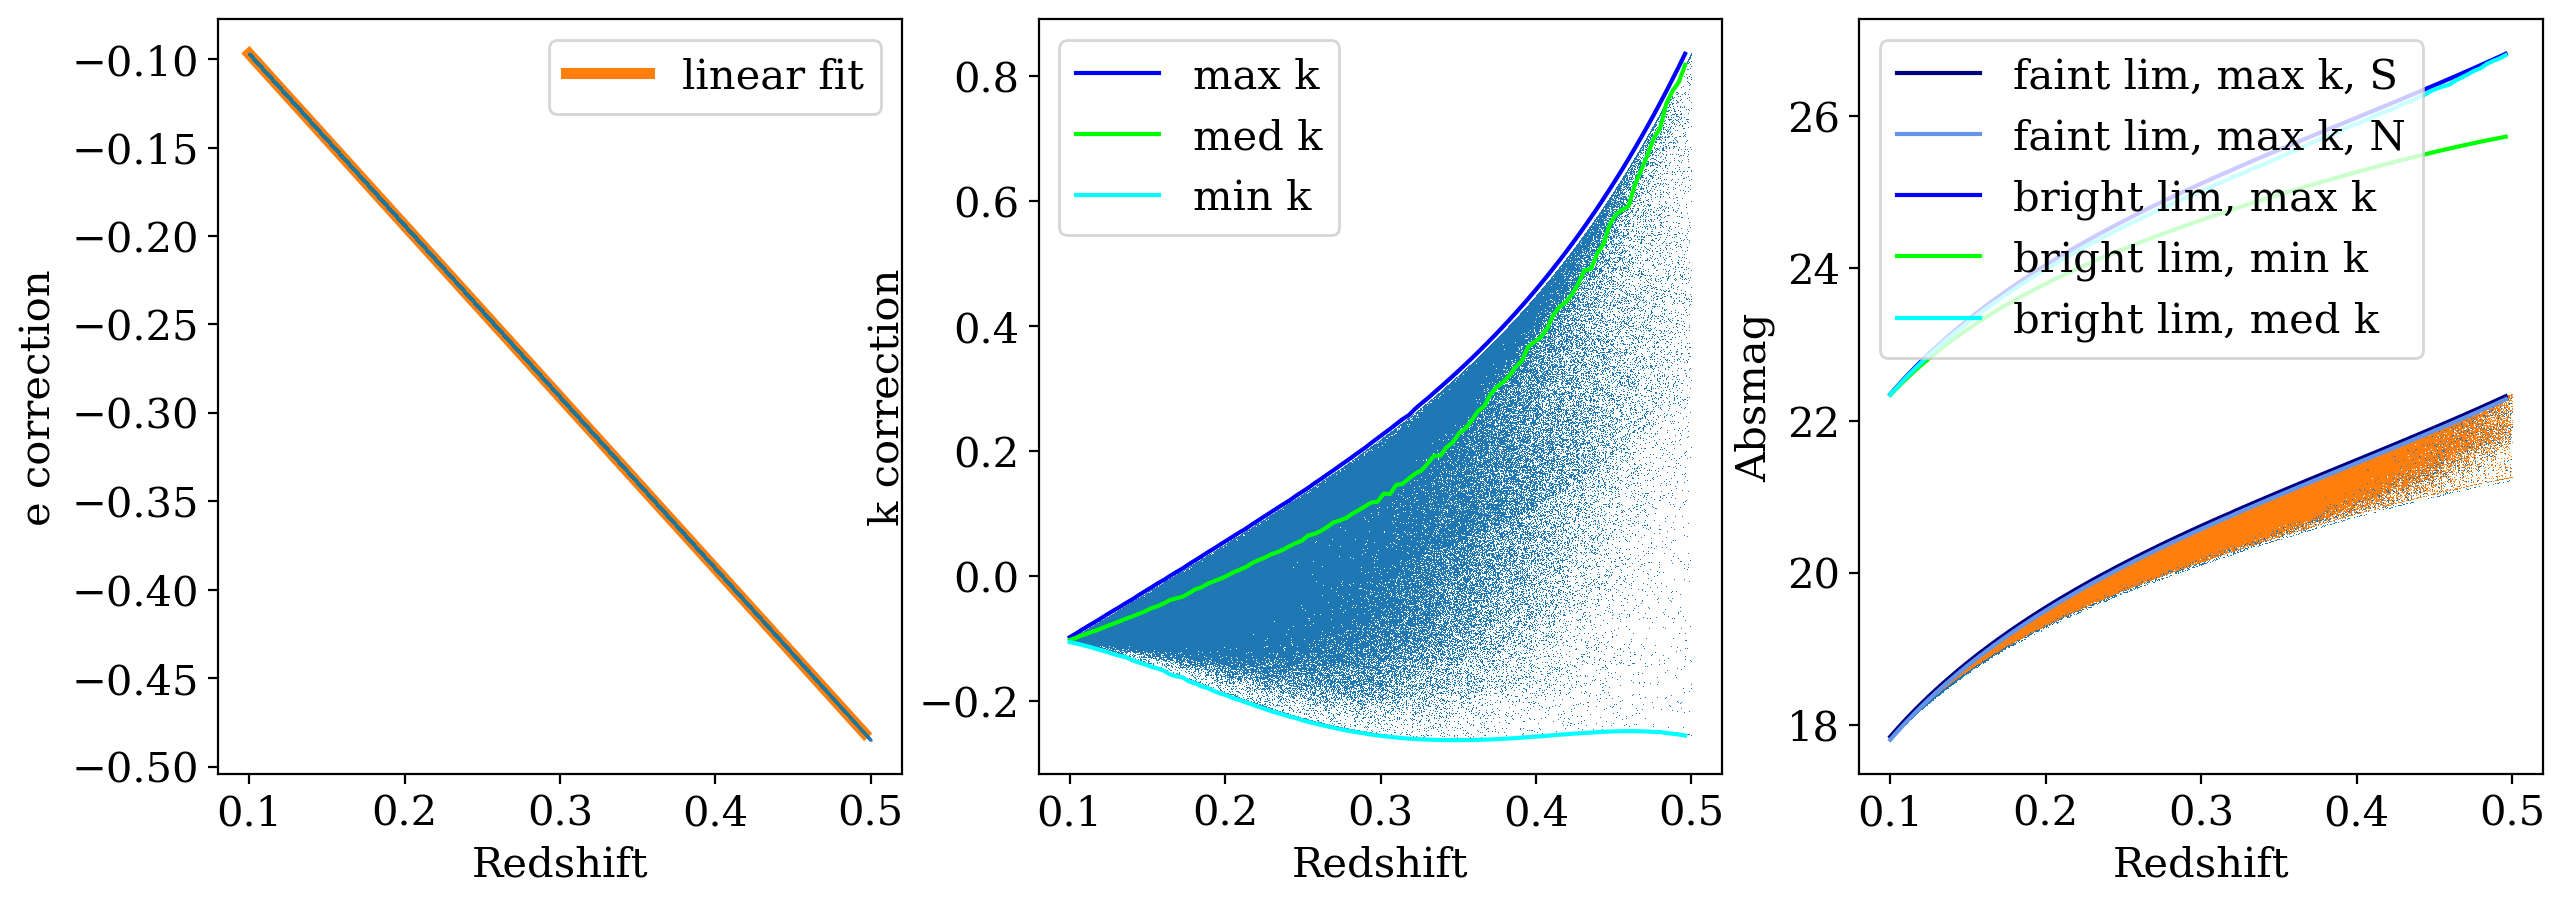

In [20]:
plt.figure(figsize=(15,5), dpi=200)

plt.subplot(131)
plt.plot(z_range[0:-1], e_z, label='linear fit', color='tab:orange', lw=4)
plt.plot(data['Z'], data['EQ_ALL_0P1'], lw=0, marker='o', color='tab:blue', markersize=0.01)
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('e correction')

plt.subplot(132)
plt.plot(data['Z'], data['KCORR_R0P1'], lw=0, marker=',')
plt.plot(z_range[0:-1], k_max, color='blue', label='max k')
plt.plot(z_range[0:-1], k_med, color='lime', label='med k')
plt.plot(z_range[0:-1], k_min, color='aqua', label='min k')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('k correction')

plt.subplot(133)
plt.plot(data['Z'], -data['ABSMAG_LIM'], lw=0, marker=',')
plt.plot(data['Z'],-absmag(19.5, np.array(data['Z']), np.array(data['KCORR_R0P1']), np.array(data['EQ_ALL_0P1'])),lw=0,marker=',')
plt.plot(z_range[0:-1], -faintlim_range_S_max, color='navy', label='faint lim, max k, S')
plt.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
#plt.plot(z_range[0:-1], -faintlim_range_S_med, color='lime', label='med k, S')
#plt.plot(z_range[0:-1], -faintlim_range_N_med, color='palegreen', label='med k, N')
#plt.plot(z_range[0:-1], -faintlim_range_S_min, color='aqua', label='min k, S')
#plt.plot(z_range[0:-1], -faintlim_range_N_min, color='darkturquoise', label='min k, N')
plt.plot(z_range[0:-1], -brightlim_range_max, color='blue', label='bright lim, max k')
plt.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
plt.plot(z_range[0:-1], -brightlim_range_med, color='aqua', label='bright lim, med k')


plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Absmag')
plt.savefig('../figures/week8/da02_corrections_and_absmag.png')


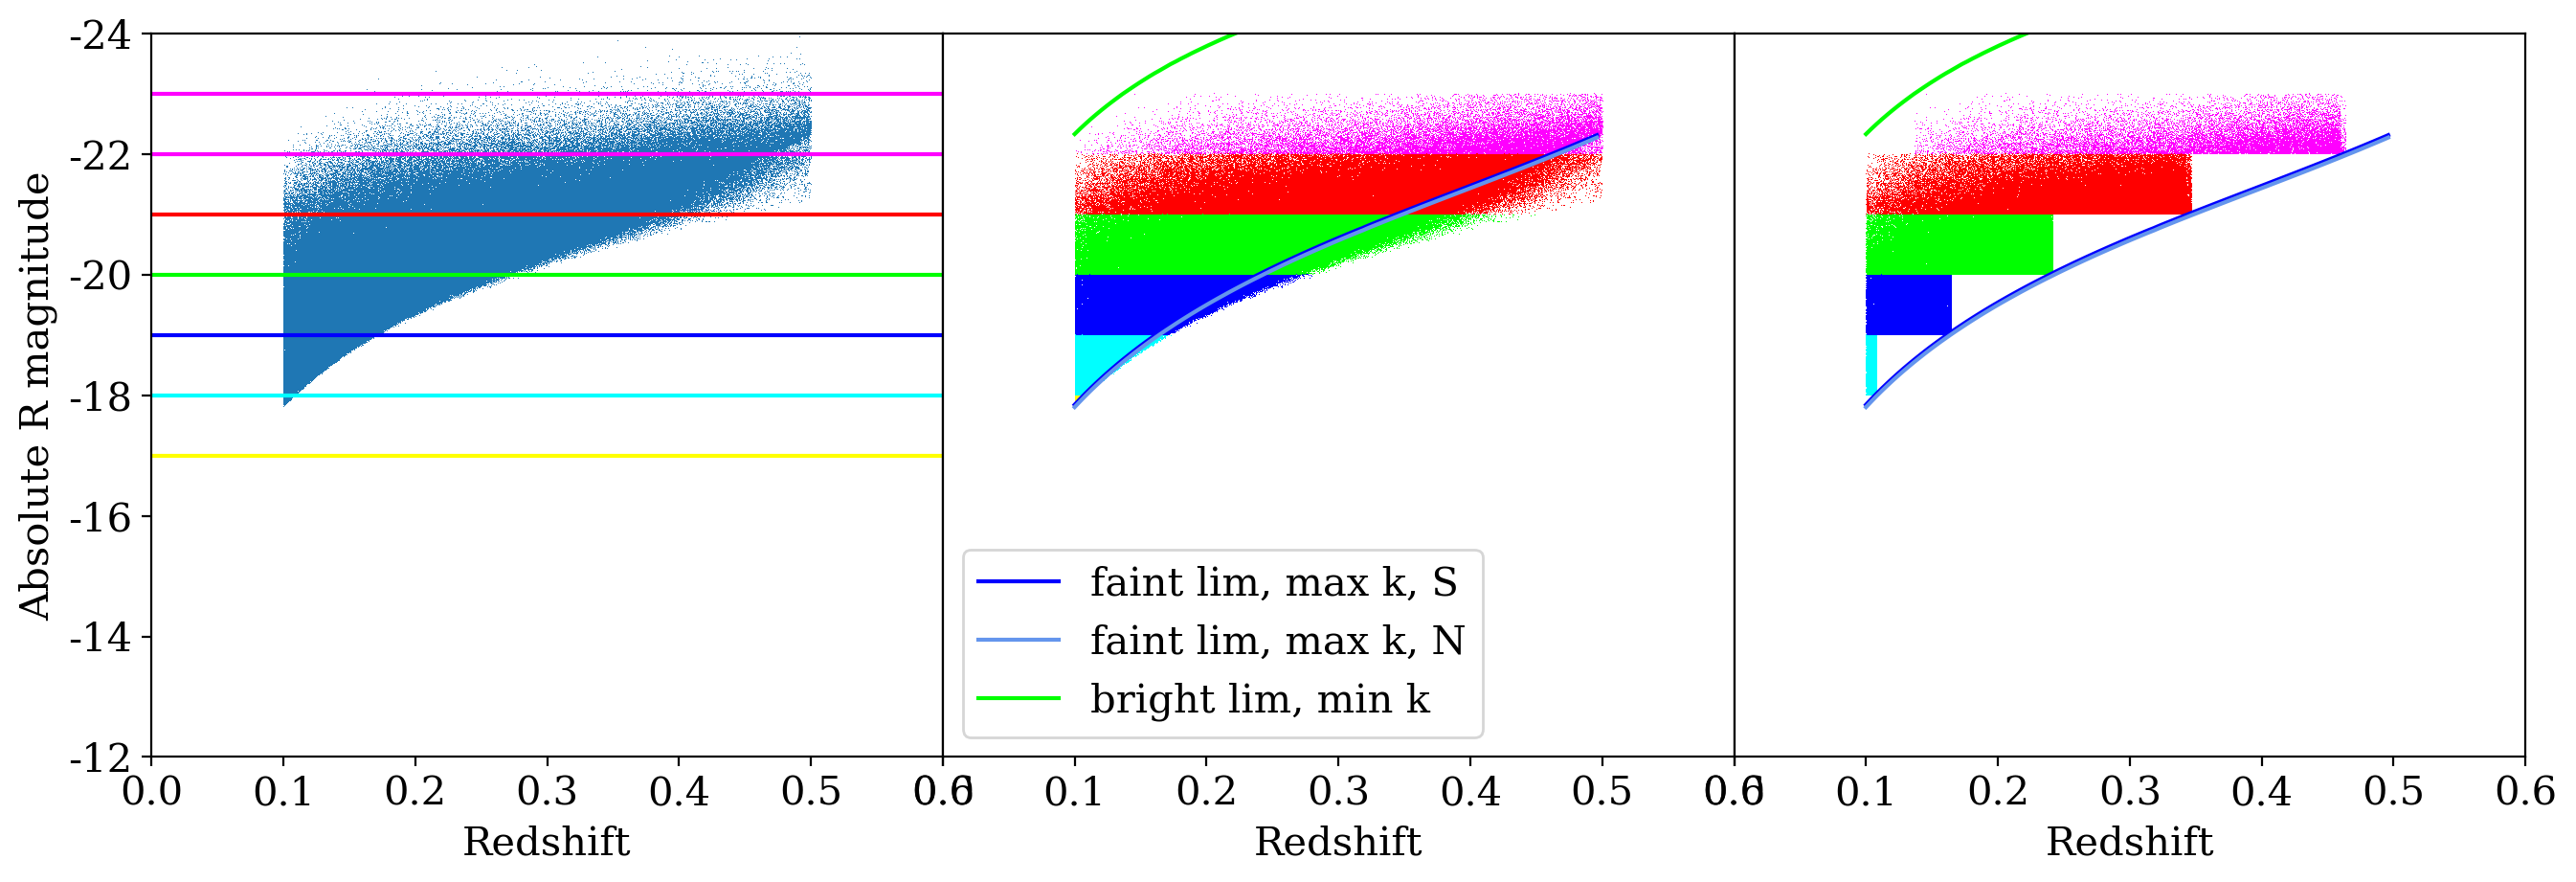

In [21]:
plt.figure(figsize=(16,5), dpi=200)
ax1 = plt.subplot(131)
ax1.plot(data['Z'], -data['ABSMAG_RP1'], lw=0, marker=',')
ax1.plot([0,0.6],[17,17], color='yellow')
ax1.plot([0,0.6],[18,18], color='cyan')
ax1.plot([0,0.6],[19,19], color='blue')
ax1.plot([0,0.6],[20,20], color='lime')
ax1.plot([0,0.6],[21,21], color='red')
ax1.plot([0,0.6],[22,22], color='magenta')
ax1.plot([0,0.6],[23,23], color='magenta')
plt.ylim(12,24)
plt.xlim(0,0.6)
plt.yticks([12,14,16,18,20,22,24],['-12','-14','-16','-18','-20','-22','-24'])
plt.xlabel('Redshift')
plt.ylabel('Absolute R magnitude')

ax2 = plt.subplot(132)
ax2.plot(data['Z'][absmag_lim(-17,-18, data)], -data['ABSMAG_RP1'][absmag_lim(-17,-18, data)], lw=0, marker=',', color='yellow')
ax2.plot(data['Z'][absmag_lim(-18,-19, data)], -data['ABSMAG_RP1'][absmag_lim(-18,-19, data)], lw=0, marker=',', color='cyan')
ax2.plot(data['Z'][absmag_lim(-19,-20, data)], -data['ABSMAG_RP1'][absmag_lim(-19,-20, data)], lw=0, marker=',', color='blue')
ax2.plot(data['Z'][absmag_lim(-20,-21, data)], -data['ABSMAG_RP1'][absmag_lim(-20,-21, data)], lw=0, marker=',', color='lime')
ax2.plot(data['Z'][absmag_lim(-21,-22, data)], -data['ABSMAG_RP1'][absmag_lim(-21,-22, data)], lw=0, marker=',', color='red')
ax2.plot(data['Z'][absmag_lim(-22,-23, data)], -data['ABSMAG_RP1'][absmag_lim(-22,-23, data)], lw=0, marker=',', color='magenta')
#ax2.plot(zmax_range, -M_range, color='tab:blue', lw=1, label='my estimate')
ax2.plot(z_range[0:-1], -faintlim_range_S_max, color='blue', label='faint lim, max k, S')
ax2.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
#plt.plot(z_range[0:-1], -faintlim_range_S_med, color='lime', label='med k, S')

#plt.plot(z_range[0:-1], -faintlim_range_S_min, color='aqua', label='min k, S')
#plt.plot(z_range[0:-1], -brightlim_range_max, color='blue', label='bright lim, max k')
ax2.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
#plt.plot(z_range[0:-1], -brightlim_range_med, color='aqua', label='bright lim, med k')

#ax2.plot(data['ZMAX'], -data['ABSMAG_RP1'], lw=0, marker=',', color='orange')

plt.legend()
plt.yticks([])
plt.ylim(12,24)
plt.xlim(0,0.6)
plt.xlabel('Redshift')

sample1718 = np.intersect1d(absmag_lim(-17,-18, data), redshift_lim_from_k(-17,-18, data)[1])
sample1819 = np.intersect1d(absmag_lim(-18,-19, data), redshift_lim_from_k(-18,-19, data)[1])
sample1920 = np.intersect1d(absmag_lim(-19,-20, data), redshift_lim_from_k(-19,-20, data)[1])
sample2021 = np.intersect1d(absmag_lim(-20,-21, data), redshift_lim_from_k(-20,-21, data)[1])
sample2122 = np.intersect1d(absmag_lim(-21,-22, data), redshift_lim_from_k(-21,-22, data)[1])
sample2223 = np.intersect1d(absmag_lim(-22,-23, data), redshift_lim_from_k(-22,-23, data)[1])


ax3 = plt.subplot(133)
ax3.plot(data['Z'][sample1718], -data['ABSMAG_RP1'][sample1718], lw=0, marker=',', color='yellow')
ax3.plot(data['Z'][sample1819], -data['ABSMAG_RP1'][sample1819], lw=0, marker=',', color='cyan')
ax3.plot(data['Z'][sample1920], -data['ABSMAG_RP1'][sample1920], lw=0, marker=',', color='blue')
ax3.plot(data['Z'][sample2021], -data['ABSMAG_RP1'][sample2021], lw=0, marker=',', color='lime')
ax3.plot(data['Z'][sample2122], -data['ABSMAG_RP1'][sample2122], lw=0, marker=',', color='red')
ax3.plot(data['Z'][sample2223], -data['ABSMAG_RP1'][sample2223], lw=0, marker=',', color='magenta')
ax3.plot(z_range[0:-1], -faintlim_range_S_max, color='blue', label='faint lim, max k, S')
ax3.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
ax3.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
plt.yticks([])
plt.ylim(12,24)
plt.xlim(0,0.6)

plt.xlabel('Redshift')
plt.subplots_adjust(wspace=0)
plt.savefig('../figures/week8/DA02_mag_v_redshift.png')

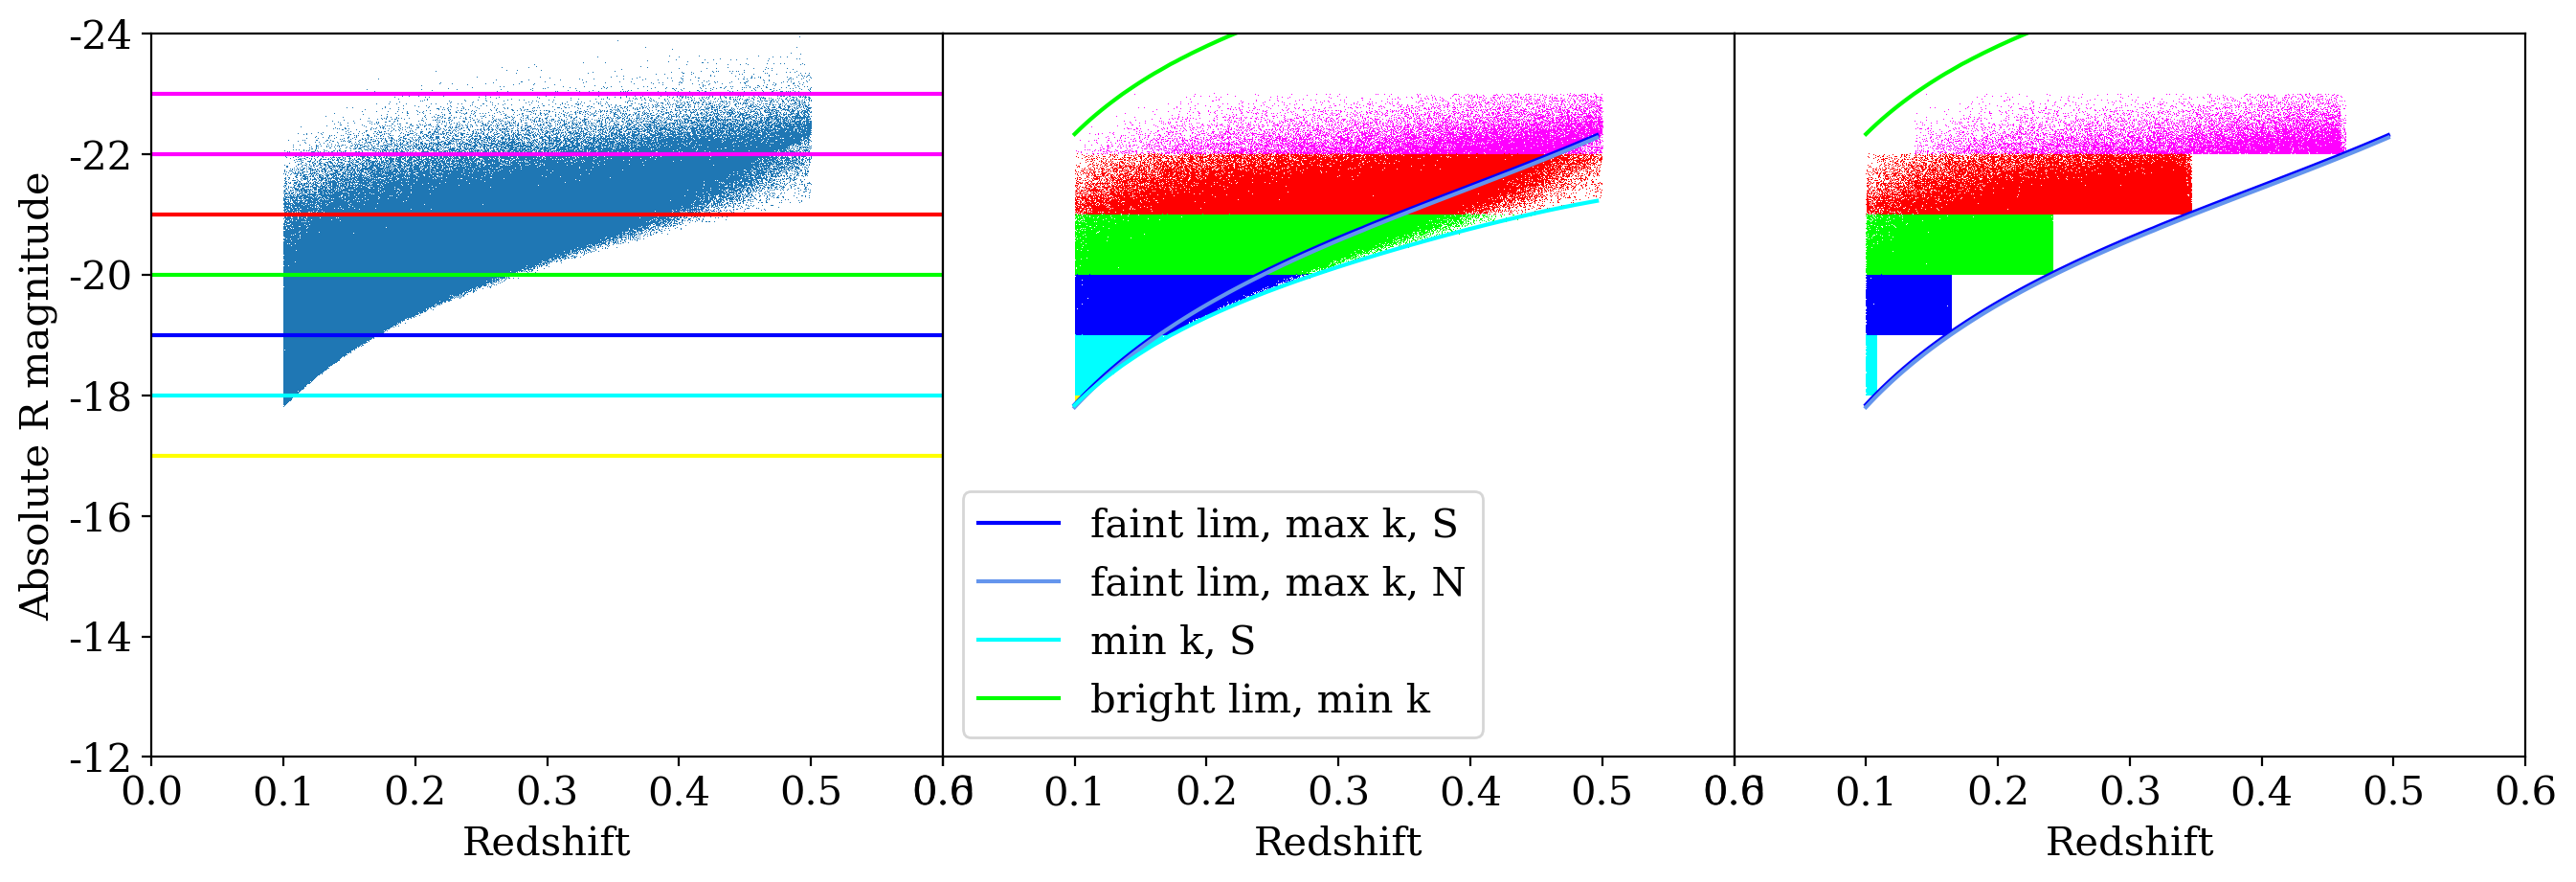

In [22]:
z_range = np.linspace(0.1,0.5,100)

plt.figure(figsize=(16,5), dpi=200)
ax1 = plt.subplot(131)
ax1.plot(ran['Z'], -ran['ABSMAG_RP1'], lw=0, marker=',')
ax1.plot([0,0.6],[17,17], color='yellow')
ax1.plot([0,0.6],[18,18], color='cyan')
ax1.plot([0,0.6],[19,19], color='blue')
ax1.plot([0,0.6],[20,20], color='lime')
ax1.plot([0,0.6],[21,21], color='red')
ax1.plot([0,0.6],[22,22], color='magenta')
ax1.plot([0,0.6],[23,23], color='magenta')
plt.ylim(12,24)
plt.xlim(0,0.6)
plt.yticks([12,14,16,18,20,22,24],['-12','-14','-16','-18','-20','-22','-24'])
plt.xlabel('Redshift')
plt.ylabel('Absolute R magnitude')

ax2 = plt.subplot(132)
ax2.plot(ran['Z'][absmag_lim(-17,-18, ran)], -ran['ABSMAG_RP1'][absmag_lim(-17,-18, ran)], lw=0, marker=',', color='yellow')
ax2.plot(ran['Z'][absmag_lim(-18,-19, ran)], -ran['ABSMAG_RP1'][absmag_lim(-18,-19, ran)], lw=0, marker=',', color='cyan')
ax2.plot(ran['Z'][absmag_lim(-19,-20, ran)], -ran['ABSMAG_RP1'][absmag_lim(-19,-20, ran)], lw=0, marker=',', color='blue')
ax2.plot(ran['Z'][absmag_lim(-20,-21, ran)], -ran['ABSMAG_RP1'][absmag_lim(-20,-21, ran)], lw=0, marker=',', color='lime')
ax2.plot(ran['Z'][absmag_lim(-21,-22, ran)], -ran['ABSMAG_RP1'][absmag_lim(-21,-22, ran)], lw=0, marker=',', color='red')
ax2.plot(ran['Z'][absmag_lim(-22,-23, ran)], -ran['ABSMAG_RP1'][absmag_lim(-22,-23, ran)], lw=0, marker=',', color='magenta')
#ax2.plot(zmax_range, -M_range, color='tab:blue', lw=1, label='my estimate')
ax2.plot(z_range[0:-1], -faintlim_range_S_max, color='blue', label='faint lim, max k, S')
ax2.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
#plt.plot(z_range[0:-1], -faintlim_range_S_med, color='lime', label='med k, S')

plt.plot(z_range[0:-1], -faintlim_range_S_min, color='aqua', label='min k, S')
#plt.plot(z_range[0:-1], -brightlim_range_max, color='blue', label='bright lim, max k')
ax2.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
#plt.plot(z_range[0:-1], -brightlim_range_med, color='aqua', label='bright lim, med k')

#ax2.plot(ran['ZMAX'], -ran['ABSMAG_R'], lw=0, marker=',', color='orange')


plt.legend()
plt.yticks([])
plt.ylim(12,24)
plt.xlim(0,0.6)
plt.xlabel('Redshift')

ran_sample1718 = np.intersect1d(absmag_lim(-17,-18, ran), redshift_lim_from_k(-17,-18, ran)[1])
ran_sample1819 = np.intersect1d(absmag_lim(-18,-19, ran), redshift_lim_from_k(-18,-19, ran)[1])
ran_sample1920 = np.intersect1d(absmag_lim(-19,-20, ran), redshift_lim_from_k(-19,-20, ran)[1])
ran_sample2021 = np.intersect1d(absmag_lim(-20,-21, ran), redshift_lim_from_k(-20,-21, ran)[1])
ran_sample2122 = np.intersect1d(absmag_lim(-21,-22, ran), redshift_lim_from_k(-21,-22, ran)[1])
ran_sample2223 = np.intersect1d(absmag_lim(-22,-23, ran), redshift_lim_from_k(-22,-23, ran)[1])

ax3 = plt.subplot(133)
ax3.plot(ran['Z'][ran_sample1718], -ran['ABSMAG_RP1'][ran_sample1718], lw=0, marker=',', color='yellow')
ax3.plot(ran['Z'][ran_sample1819], -ran['ABSMAG_RP1'][ran_sample1819], lw=0, marker=',', color='cyan')
ax3.plot(ran['Z'][ran_sample1920], -ran['ABSMAG_RP1'][ran_sample1920], lw=0, marker=',', color='blue')
ax3.plot(ran['Z'][ran_sample2021], -ran['ABSMAG_RP1'][ran_sample2021], lw=0, marker=',', color='lime')
ax3.plot(ran['Z'][ran_sample2122], -ran['ABSMAG_RP1'][ran_sample2122], lw=0, marker=',', color='red')
ax3.plot(ran['Z'][ran_sample2223], -ran['ABSMAG_RP1'][ran_sample2223], lw=0, marker=',', color='magenta')
ax3.plot(z_range[0:-1], -faintlim_range_S_max, color='blue', label='faint lim, max k, S')
ax3.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
ax3.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
plt.yticks([])
plt.ylim(12,24)
plt.xlim(0,0.6)

plt.xlabel('Redshift')
plt.subplots_adjust(wspace=0)
plt.savefig('../figures/week10/da02_ran_bright_mag_v_redshift.png')


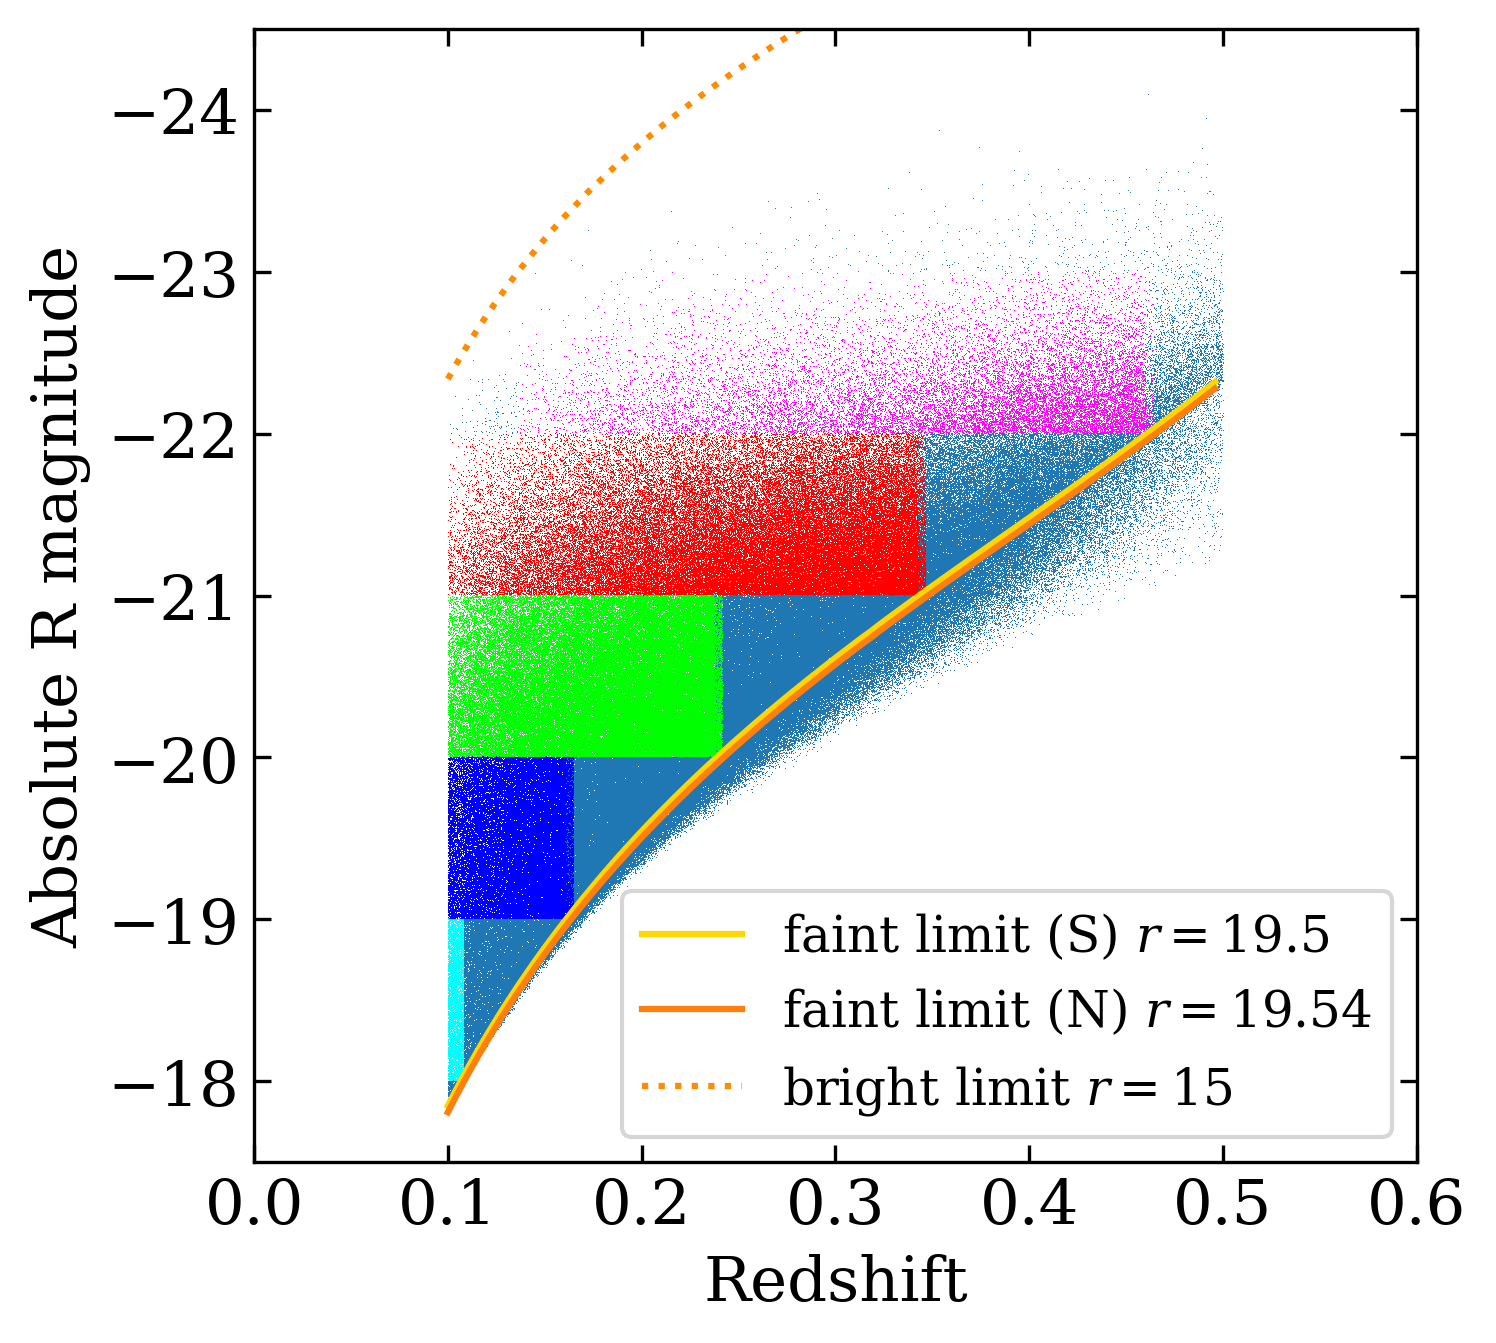

In [23]:
fig, ax1 = plt.subplots(figsize=(5,5), dpi=300)

ax1.plot(data['Z'], data['ABSMAG_RP1'], lw=0, marker=',')

plt.xlabel('Redshift')
plt.ylabel('Absolute R magnitude')

ax1.plot(data['Z'][sample1718], data['ABSMAG_RP1'][sample1718], lw=0, marker=',', color='yellow')
ax1.plot(data['Z'][sample1819], data['ABSMAG_RP1'][sample1819], lw=0, marker=',', color='cyan')
ax1.plot(data['Z'][sample1920], data['ABSMAG_RP1'][sample1920], lw=0, marker=',', color='blue')
ax1.plot(data['Z'][sample2021], data['ABSMAG_RP1'][sample2021], lw=0, marker=',', color='lime')
ax1.plot(data['Z'][sample2122], data['ABSMAG_RP1'][sample2122], lw=0, marker=',', color='red')
ax1.plot(data['Z'][sample2223], data['ABSMAG_RP1'][sample2223], lw=0, marker=',', color='magenta')
ax1.plot(z_range[0:-1], faintlim_range_S_max, color='gold', ls ='-', label='faint limit (S) $r=19.5$')
ax1.plot(z_range[0:-1], faintlim_range_N_max, color='tab:orange', ls='-', label='faint limit (N) $r=19.5$4')
ax1.plot(z_range[0:-1], brightlim_range_min, color='darkorange', ls=':', label='bright limit $r=15$')

plt.ylim(-24.5,-17.5)
plt.xlim(0,0.6)
ax1.tick_params(axis='both', which='major', direction='in', top=True, right=True, length=4)

plt.gca().invert_yaxis()
plt.xlabel('Redshift')
plt.legend(loc='lower right', fontsize=12)

plt.savefig('../figures/interim/da02_vol_lim_samples.png', bbox_inches='tight')


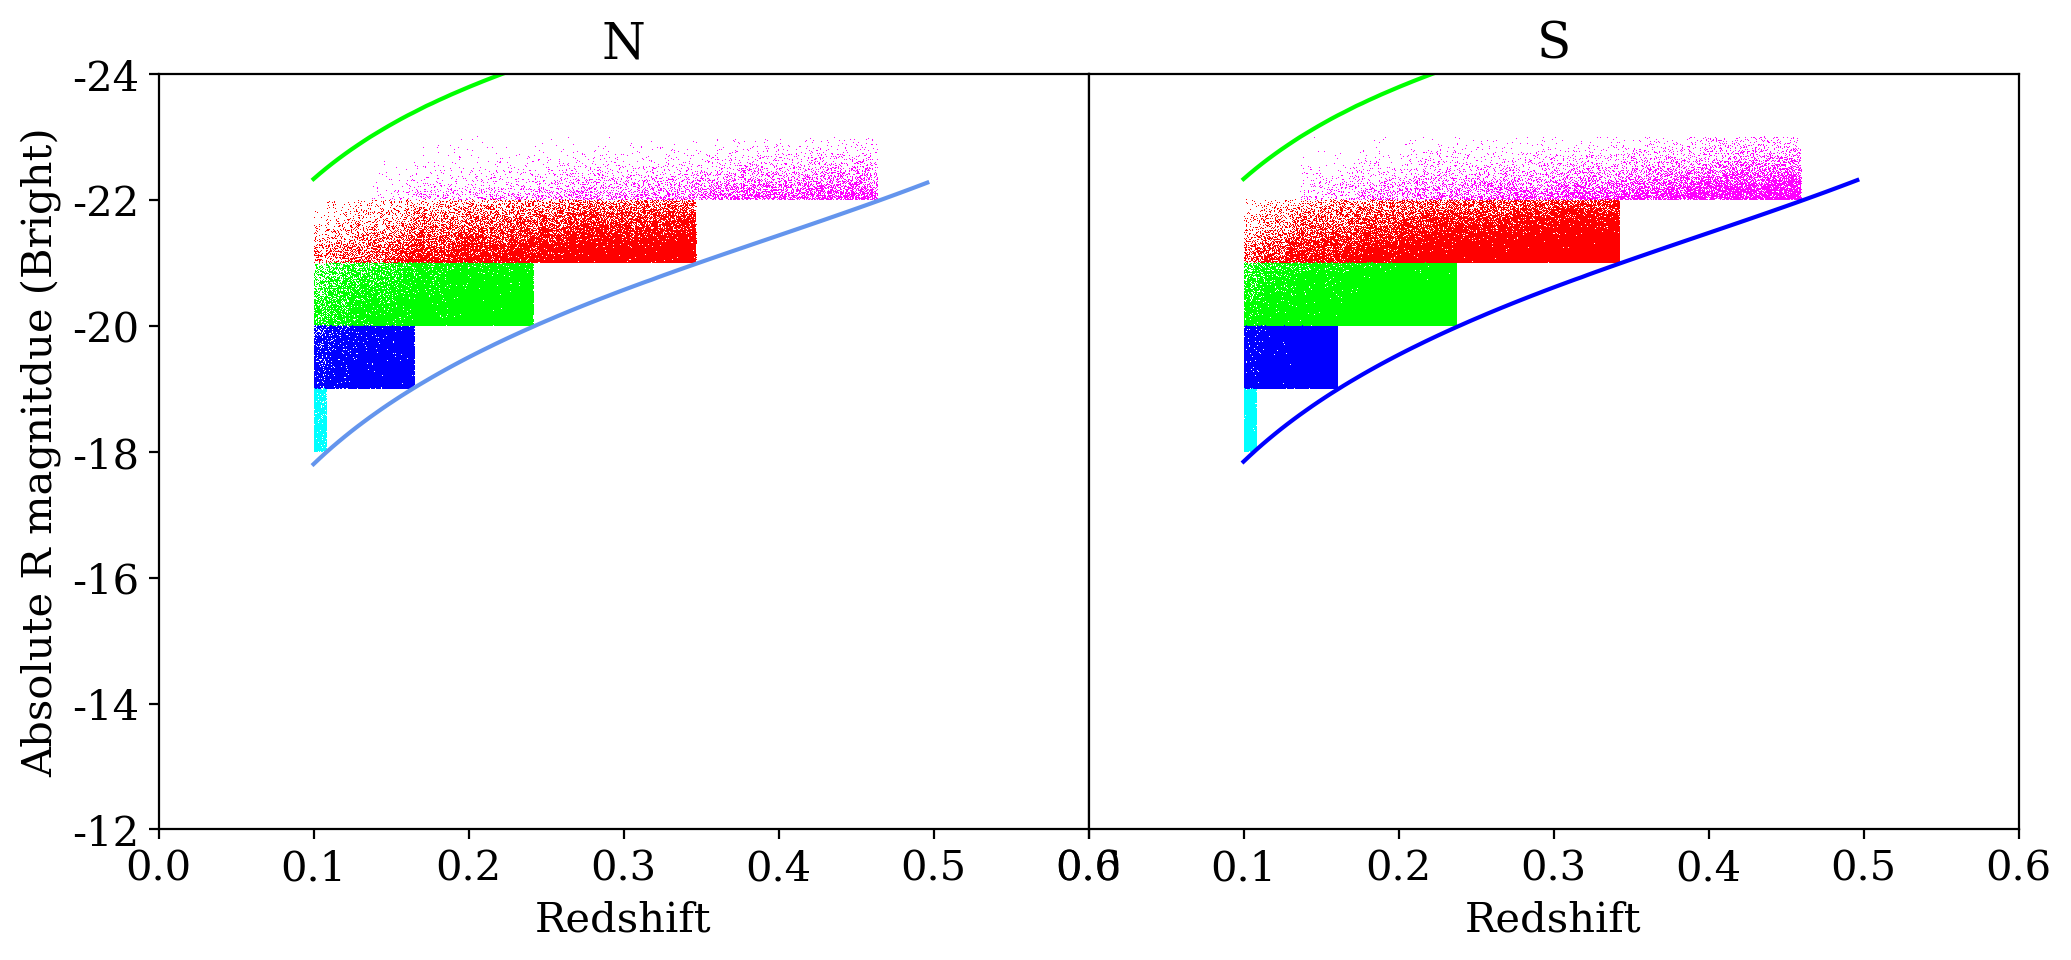

In [24]:
plt.figure(figsize=(12,5), dpi=200)

ax2 = plt.subplot(121)
plt.title('N')
ax2.plot(N['Z'][np.intersect1d(absmag_lim(-17,-18, N), redshift_lim_from_k(-17,-18, N)[1])], -N['ABSMAG_RP1'][np.intersect1d(absmag_lim(-17,-18, N), redshift_lim_from_k(-17,-18, N)[1])], lw=0, marker=',', color='yellow')
ax2.plot(N['Z'][np.intersect1d(absmag_lim(-18,-19, N), redshift_lim_from_k(-18,-19, N)[1])], -N['ABSMAG_RP1'][np.intersect1d(absmag_lim(-18,-19, N), redshift_lim_from_k(-18,-19, N)[1])], lw=0, marker=',', color='aqua')
ax2.plot(N['Z'][np.intersect1d(absmag_lim(-19,-20, N), redshift_lim_from_k(-19,-20, N)[1])], -N['ABSMAG_RP1'][np.intersect1d(absmag_lim(-19,-20, N), redshift_lim_from_k(-19,-20, N)[1])], lw=0, marker=',', color='blue')
ax2.plot(N['Z'][np.intersect1d(absmag_lim(-20,-21, N), redshift_lim_from_k(-20,-21, N)[1])], -N['ABSMAG_RP1'][np.intersect1d(absmag_lim(-20,-21, N), redshift_lim_from_k(-20,-21, N)[1])], lw=0, marker=',', color='lime')
ax2.plot(N['Z'][np.intersect1d(absmag_lim(-21,-22, N), redshift_lim_from_k(-21,-22, N)[1])], -N['ABSMAG_RP1'][np.intersect1d(absmag_lim(-21,-22, N), redshift_lim_from_k(-21,-22, N)[1])], lw=0, marker=',', color='red')
ax2.plot(N['Z'][np.intersect1d(absmag_lim(-22,-23, N), redshift_lim_from_k(-22,-23, N)[1])], -N['ABSMAG_RP1'][np.intersect1d(absmag_lim(-22,-23, N), redshift_lim_from_k(-22,-23, N)[1])], lw=0, marker=',', color='magenta')
#ax2.plot(zmax_range_bright, -M_range, color='tab:blue', lw=1)
ax2.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
ax2.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
plt.yticks([12,14,16,18,20,22,24],['-12','-14','-16','-18','-20','-22','-24'])
plt.ylim(12,24)
plt.xlim(0,0.6)
plt.xlabel('Redshift')
plt.ylabel('Absolute R magnitdue (Bright)')

ax3 = plt.subplot(122)
plt.title('S')
ax3.plot(S['Z'][np.intersect1d(absmag_lim(-17,-18, S), redshift_lim_from_k(-17,-18, S)[1])], -S['ABSMAG_RP1'][np.intersect1d(absmag_lim(-17,-18, S), redshift_lim_from_k(-17,-18, S)[1])], lw=0, marker=',', color='yellow')
ax3.plot(S['Z'][np.intersect1d(absmag_lim(-18,-19, S), redshift_lim_from_k(-18,-19, S)[1])], -S['ABSMAG_RP1'][np.intersect1d(absmag_lim(-18,-19, S), redshift_lim_from_k(-18,-19, S)[1])], lw=0, marker=',', color='aqua')
ax3.plot(S['Z'][np.intersect1d(absmag_lim(-19,-20, S), redshift_lim_from_k(-19,-20, S)[1])], -S['ABSMAG_RP1'][np.intersect1d(absmag_lim(-19,-20, S), redshift_lim_from_k(-19,-20, S)[1])], lw=0, marker=',', color='blue')
ax3.plot(S['Z'][np.intersect1d(absmag_lim(-20,-21, S), redshift_lim_from_k(-20,-21, S)[1])], -S['ABSMAG_RP1'][np.intersect1d(absmag_lim(-20,-21, S), redshift_lim_from_k(-20,-21, S)[1])], lw=0, marker=',', color='lime')
ax3.plot(S['Z'][np.intersect1d(absmag_lim(-21,-22, S), redshift_lim_from_k(-21,-22, S)[1])], -S['ABSMAG_RP1'][np.intersect1d(absmag_lim(-21,-22, S), redshift_lim_from_k(-21,-22, S)[1])], lw=0, marker=',', color='red')
ax3.plot(S['Z'][np.intersect1d(absmag_lim(-22,-23, S), redshift_lim_from_k(-22,-23, S)[1])], -S['ABSMAG_RP1'][np.intersect1d(absmag_lim(-22,-23, S), redshift_lim_from_k(-22,-23, S)[1])], lw=0, marker=',', color='magenta')
#ax3.plot(zmax_range_bright, -M_range, color='tab:blue', lw=1)S
ax3.plot(z_range[0:-1], -faintlim_range_S_max, color='blue', label='faint lim, max k, S')
ax3.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
plt.yticks([])
plt.ylim(12,24)
plt.xlim(0,0.6)

plt.xlabel('Redshift')
plt.subplots_adjust(wspace=0)
plt.savefig('../figures/week8/main_mag_v_redshift_bright_NS.png')


Luminosity function

In [25]:
def phi(M, phi_star=8.32*10**(-3), M_star=-20.3, alpha=-0.23): #luminosity function
    return np.log(10)*phi_star*10**(0.4*(alpha+1)*(-M+M_star))*np.exp(-10**(0.4*(-M+M_star)))/2.5

In [26]:
N0 = Table.read('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/clustering/BGS_ANY_N_0_clustering.ran.fits')
S0 = Table.read('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/clustering/BGS_ANY_S_0_clustering.ran.fits')

print(np.shape(N0)[0] + np.shape(S0)[0])
sky_area = 4*np.pi*np.rad2deg(1)**2
print(sky_area)
survey_area = 434393 / 2500 #randoms / deg^2
print(survey_area) # in deg^2
fsky = survey_area/sky_area
print(fsky)

A = 705.5096+1160.9628
fsky_hdr = A/sky_area
print(fsky_hdr)
#these are different - different random number density? use fsky_hdr

434393
41252.96124941928
173.7572
0.004211993387564293
0.04524456774666751


In [27]:
data

TARGETID,Z,NTILE,TILES,RA,DEC,WEIGHT,WEIGHT_ZFAIL,WEIGHT_COMP,WEIGHT_SYS,flux_g_dered,flux_r_dered,flux_z_dered,flux_w1_dered,flux_w2_dered,NZ,WEIGHT_FKP,REST_GMR_0P1,KCORR_R0P1,KCORR_G0P1,KCORR_R0P0,KCORR_G0P0,REST_GMR_0P0,EQ_ALL_0P0,EQ_ALL_0P1,ABSMAG_RP1,ABSMAG_RP0,APPLIM,ZLIM_UPPER,DL,ABSMAG_LIM,ZMAX
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,,
int64,float64,int64,bytes11,float64,float64,float64,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633366047264297,0.16095951646742163,1,20001,268.7008850398322,58.31651750837625,2.368794267525197,1.0202607,2.0,1.1608769635685512,7.7169294,16.809292,28.698618,21.945616,12.552565,0.01856145426373512,0.016762400045732102,0.721548822097457,-0.0480892836645471,0.07562442170381622,0.17676402087349832,0.38471493423821956,0.637311614101099,-0.15613073097339897,-0.15613073097339897,-19.01505339080518,-19.239906695343226,19.539993,0.4636363636363636,539.3514173803549,-18.915146107200922,0.17272727272727273
39633366047264412,0.2262081883049673,1,20001,268.7121644210125,58.17137871856034,7.885935437241774,1.0119702,7.0,1.1132365826456456,5.6451545,17.743734,36.715954,42.338474,30.138641,0.008661962234134126,0.03524444880947024,0.8916872718248806,0.055141909042679765,0.4068761917832286,0.28235492619244257,0.7782674152354703,0.7475090655224019,-0.21942194265581827,-0.21942194265581827,-19.934640009395764,-20.16185302654553,19.539993,0.4636363636363636,787.7047657932226,-19.77754433167579,0.2737373737373737
39633366047264710,0.20509598282456507,1,20001,268.7447179685751,58.35164090788789,3.5493453409436366,1.0191563,3.0,1.1608769635685512,9.199382,18.115196,31.323214,38.144897,31.80481,0.011911149469520776,0.025879084952906813,0.5397214238839109,-0.06256931584764004,0.13341940431141774,0.14342391928728798,0.37673369579311694,0.5024003675371398,-0.19894310333982812,-0.19894310333982812,-19.621429255164735,-19.82742249029966,19.539993,0.4636363636363636,705.617526120866,-19.441341377110582,0.23333333333333334
39633378638561503,0.3053206447975358,1,20001,270.5073482253405,59.33896919077583,2.3158908743540527,1.0118785,2.0,1.1443522597899662,5.816003,24.00663,49.666294,60.648766,39.263374,0.0032132398416806277,0.08965087986982612,0.948196974030458,0.1920467162085221,0.783116328481775,0.4201382412002311,1.1720507422145277,0.7873540852894143,-0.2961610254536097,-0.2961610254536097,-21.06440409622748,-21.29249562121919,19.539993,0.4636363636363636,1109.1828398978914,-20.580908400822697,0.4555555555555556
39633372376467396,0.2775320962351793,1,20001,268.5121713053863,58.81550252397294,3.2715555825991145,1.0216688,3.0,1.067389487000734,4.9087415,18.647816,47.224636,121.78173,128.69661,0.006279602345083299,0.047974048180681544,0.9314978452803849,0.14147467853484277,0.6591231040064112,0.36796505192895507,1.0449898286507322,0.7721214940301759,-0.26920613334812393,-0.26920613334812393,-20.528724008118733,-20.755214381512847,19.539993,0.4636363636363636,993.8393864610398,-20.31885656571557,0.35858585858585856
39633366047264487,0.10750217420934505,1,20001,268.72025843577376,58.150995263304566,3.3792646040688217,1.0118438,3.0,1.1132365826456456,65.581665,164.53503,310.0892,251.75818,156.65999,0.026715267796619462,0.011706208574030397,0.9793147837596916,-0.09317160654032018,-0.07379673881075391,0.1383131834916128,0.320207896877415,0.8167949381034556,-0.10427710898306469,-0.10427710898306469,-20.549183985528458,-20.78066877556039,19.539993,0.4636363636363636,348.1204512009631,-17.971205973188038,0.36262626262626263
39633366047264069,0.23373774756268273,1,20001,268.6773406567538,58.196956322063585,5.65722136226266,1.0163556,5.0,1.1132365826456456,5.1988206,18.016794,36.307766,35.975773,23.484913,0.008661962234134126,0.03524444880947024,0.9539436956606155,0.08093321342091594,0.4764215093374489,0.30965139400867076,0.8662922728465651,0.7927911127392542,-0.22672561513580225,-0.

In [57]:
zmax_clipped = np.clip(data['ZMAX'], a_min=0.1, a_max=0.5)
data['VMAX'] = fsky_hdr*cosmo.comoving_volume(zmax_clipped)

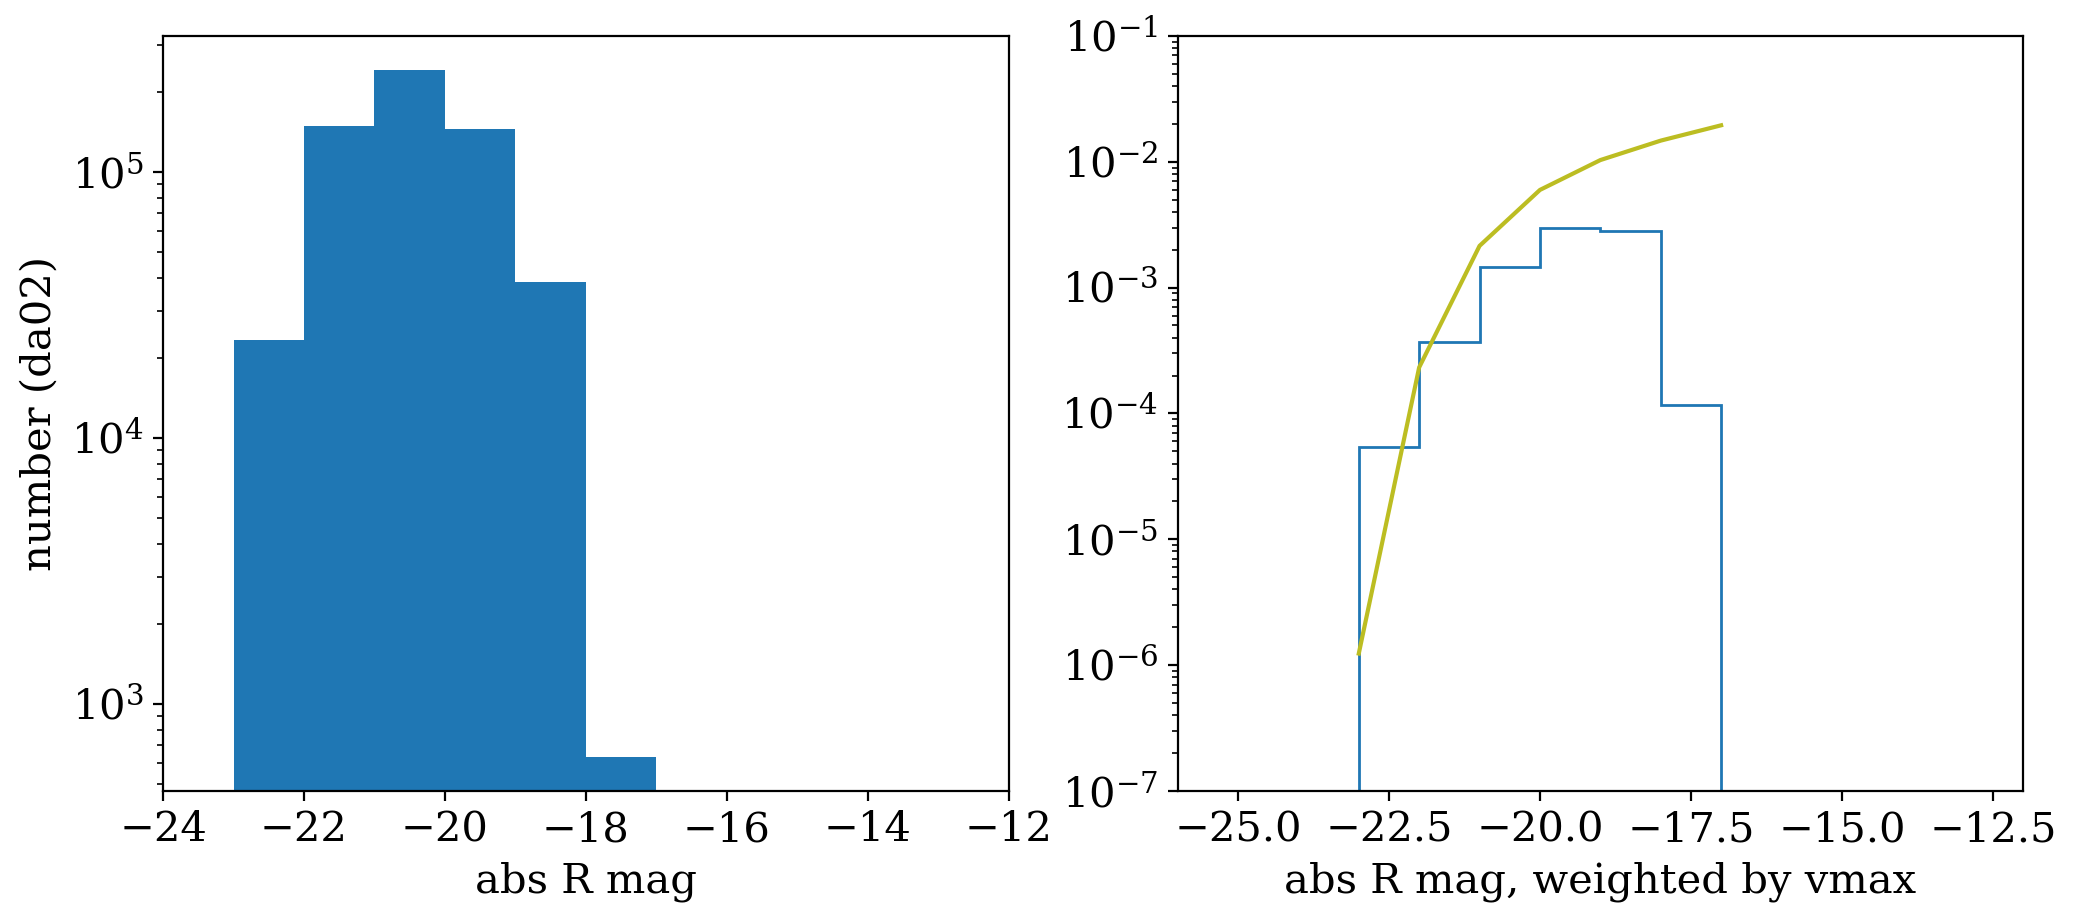

In [58]:
M_range = np.arange(-23,-16,1)
redshift_cut = np.where(data['Z'] <= 0.5)[0]

plt.figure(figsize=(12,5),dpi=200)
ax1 = plt.subplot(121)
ax1.hist(data['ABSMAG_RP1'][redshift_cut], bins=M_range)
ax1.set_yscale('log')
plt.xlabel('abs R mag')
plt.ylabel('number (da02)')
plt.xlim(-24,-12)
ax2 = plt.subplot(122)
ax2.set_yscale('log')
ax2.hist(data['ABSMAG_RP1'][redshift_cut], bins=M_range, weights=1/data['VMAX'][redshift_cut], histtype='step')
#ax2.plot(M_range, phi(M_range, phi_star=0.000000000015, M_star=-20, alpha=-1.02))
ax2.plot(M_range, phi(M_range, phi_star=10**(-2.03), M_star=-20.7, alpha=-1.25), color='tab:olive')
plt.xlabel('abs R mag, weighted by vmax')
plt.ylim(10**-7,10**-1)
plt.xlim(-26,-12)
plt.savefig('../figures/week9/da02_LF.png')

compare to sv3

In [30]:
N_sv3 = Table.read('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/clustering/BGS_BRIGHT_N_clustering.dat.fits')
S_sv3 = Table.read('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/clustering/BGS_BRIGHT_S_clustering.dat.fits')

In [31]:
data_sv3 = Table(np.hstack((N_sv3,S_sv3)))

In [32]:
z1 = find_nearest(data_sv3['Z'], 0.1)
z2 = find_nearest(data_sv3['Z'], 0.5)
e_slope_sv3 = (data_sv3['EQ_ALL_0P1'][z2] - data_sv3['EQ_ALL_0P1'][z1])/(data_sv3['Z'][z2] - data_sv3['Z'][z1])
print(data_sv3['Z'][z2], data_sv3['EQ_ALL_0P1'][z2])
print(data_sv3['Z'][z1], data_sv3['EQ_ALL_0P1'][z1])
print(e_slope_sv3)

e_intercept_sv3 = data_sv3['EQ_ALL_0P1'][z2] - e_slope_sv3*data_sv3['Z'][z2]
print(e_intercept_sv3)
#y = mx+c
z_range = np.linspace(0.01,0.6,80)  
dl_range = cosmo.luminosity_distance(z_range[0:-1]).to_value()
e_z_sv3 = e_slope_sv3*z_range[0:-1] + e_intercept_sv3 #this is correct

0.5000411802639463 -0.48503994485602786
0.10000013207827435 -0.09700012811592612
-0.9699999999999999
-5.551115123125783e-17


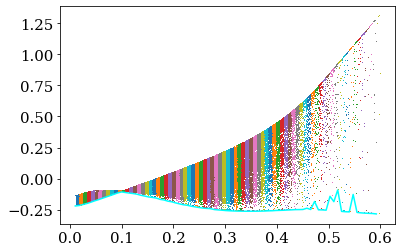

In [33]:
plt.figure()
k_min_sv3 = find_k(z_range, 'min', data_sv3)
plt.plot(z_range[0:-1], k_min_sv3, color='aqua')
plt.show()
faintlim_range_S_min_sv3 = 19.5  - 5*np.log10(dl_range) - 25 - k_min_sv3 - e_z_sv3 #this is correct

In [34]:
A_sv3 = 86.2884+87.204
sky_area = 4*np.pi*np.rad2deg(1)**2
fsky_hdr_sv3 = A_sv3/sky_area
print(fsky_hdr_sv3)

0.004205574454426402


In [56]:
data_sv3['ZMAX'] = find_zmax(data_sv3['ABSMAG_R'],faintlim_range_S_min_sv3)
zmax_clipped_sv3 = np.clip(data_sv3['ZMAX'], a_min=None, a_max=0.6)
data_sv3['VMAX'] = fsky_hdr_sv3*cosmo.comoving_volume(zmax_clipped_sv3)
redshift_cut_sv3 = np.where(data_sv3['Z'] <= 0.6)[0]
print(data_sv3['ZMAX'])

        ZMAX       
-------------------
0.09962025316455696
 0.4730379746835443
 0.2489873417721519
0.34607594936708863
0.32367088607594935
0.09962025316455696
0.27139240506329115
0.34607594936708863
0.38341772151898734
 0.5925316455696202
                ...
 0.3983544303797468
0.09962025316455696
 0.5925316455696202
 0.3535443037974684
 0.4879746835443038
 0.3012658227848101
0.34607594936708863
0.18924050632911393
 0.5178481012658228
 0.5925316455696202
0.34607594936708863
Length = 143853 rows


(-26.0, -12.0)

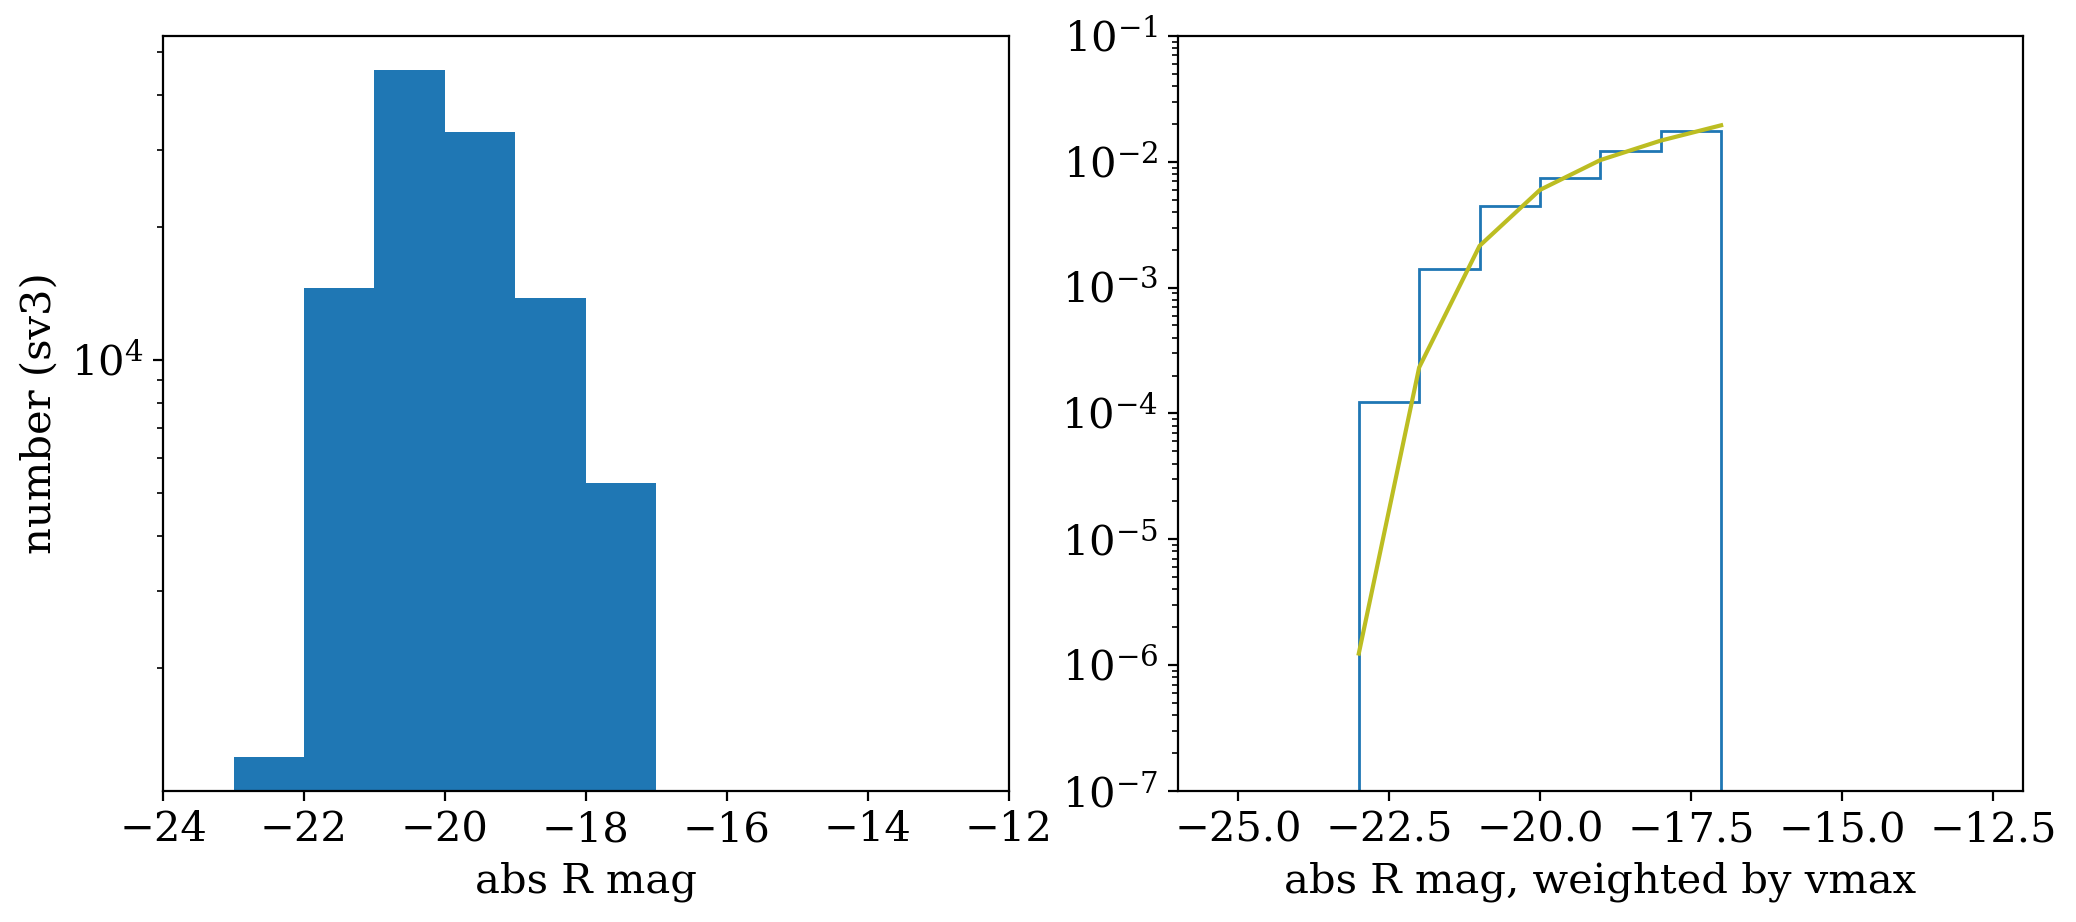

In [36]:
M_range = np.arange(-23,-16,1)
plt.figure(figsize=(12,5),dpi=200)
ax1 = plt.subplot(121)
ax1.hist(data_sv3['ABSMAG_R'][redshift_cut_sv3], bins=M_range)
ax1.set_yscale('log')
plt.xlabel('abs R mag')
plt.ylabel('number (sv3)')
plt.xlim(-24,-12)
ax2 = plt.subplot(122)
ax2.set_yscale('log')
ax2.hist(data_sv3['ABSMAG_R'][redshift_cut_sv3], bins=M_range, weights=1/data_sv3['VMAX'][redshift_cut_sv3], histtype='step')
#ax2.plot(M_range, phi(M_range, phi_star=0.000000000015, M_star=-20, alpha=-1.02))
ax2.plot(M_range, phi(M_range, phi_star=10**(-2.03), M_star=-20.7, alpha=-1.25), color='tab:olive', label='McNaught-Roberts+2014')
plt.xlabel('abs R mag, weighted by vmax')
plt.ylim(10**-7,10**-1)
plt.xlim(-26,-12)

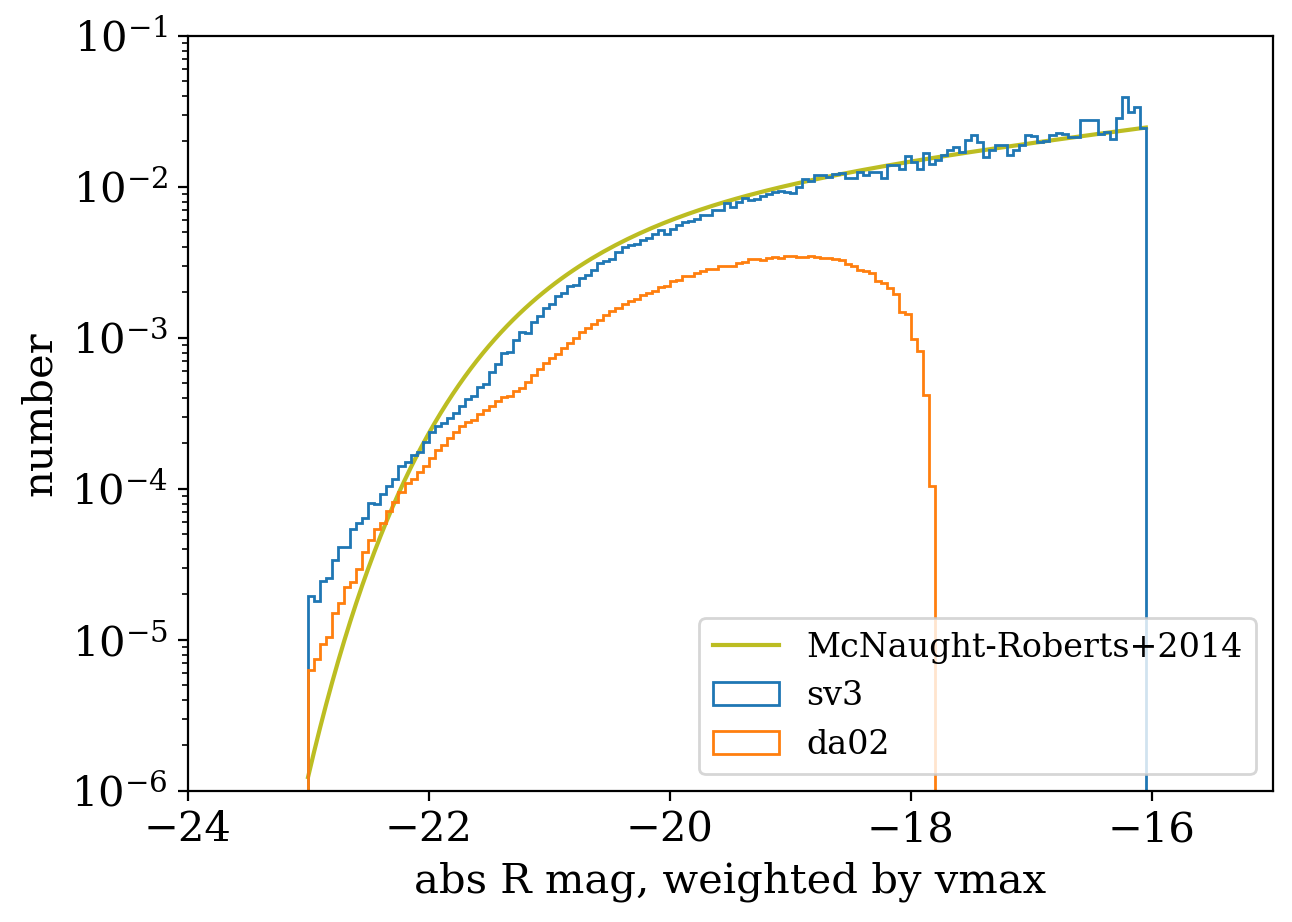

In [59]:
bin_width=0.05
M_range = np.arange(-23,-16,bin_width)
fig, ax = plt.subplots(figsize=(7,5),dpi=200)
plt.ylim(10**-7,10**-1)
plt.xlim(-26,-12)
ax.plot(M_range, phi(M_range, phi_star=10**(-2.03), M_star=-20.70, alpha=-1.25), color='tab:olive', label='McNaught-Roberts+2014')
ax.hist(data_sv3['ABSMAG_R'][redshift_cut_sv3], bins=M_range, weights=1/(bin_width*data_sv3['VMAX'][redshift_cut_sv3]), histtype='step', label='sv3')
ax.hist(data['ABSMAG_RP1'][redshift_cut], bins=M_range, weights=1/(bin_width*data['VMAX'][redshift_cut]), histtype='step', label='da02')
ax.set_yscale('log')
plt.xlim(-24,-15)
plt.ylim(10**-6,0.1)
plt.legend(fontsize=12)
plt.xlabel('abs R mag, weighted by vmax')
plt.ylabel('number')
plt.savefig('../figures/week9/LF_comparison.png')

In [38]:
def vmax(lim0, lim1, cat):
    r1 = cosmo.comoving_distance(redshift_lim_from_k(lim0,lim1,cat)[0][1])
    z2_N = redshift_lim_from_k(lim0,lim1,cat)[0][0][0]
    z2_S = redshift_lim_from_k(lim0,lim1,cat)[0][0][1]
    r2_N = cosmo.comoving_distance(z2_N)
    r2_S = cosmo.comoving_distance(z2_S)
    plt.scatter([z2_N,z2_S], [1,1])
    print(z2_N, z2_S)
    v_N = (4/3)*np.pi*fsky_hdr*(r2_N**3-r1**3).to_value()
    v_S = (4/3)*np.pi*fsky_hdr*(r2_S**3-r1**3).to_value()
    return [v_N,v_S] #Mpc**3/h

def v(lim0, lim1, z2, cat):
    r1 = cosmo.comoving_distance(redshift_lim_from_k(lim0,lim1,cat)[0][1])
    r2 = cosmo.comoving_distance(z2)
    return (4/3)*np.pi*fsky_hdr*(r2**3-r1**3).to_value()


print(redshift_lim_from_k(-22,-23,data)[0]) #[[N,S upper], lower]


IndexError: index 89 is out of bounds for axis 0 with size 80

In [ ]:
plt.figure()
data_magbins_N = Table()
data_magbins_N['TARGETID'] = N['TARGETID']
data_magbins_N['Z'] = N['Z']
data_magbins_N['ABSMAG_RP1'] = N['ABSMAG_RP1']
data_magbins_N['WEIGHT'] = N['WEIGHT']
data_magbins_N['Vmax1718'] = vmax(-17,-18,data)[0]
data_magbins_N['Vmax1819'] = vmax(-18,-19,data)[0]
data_magbins_N['Vmax1920'] = vmax(-19,-20,data)[0]
data_magbins_N['Vmax2021'] = vmax(-20,-21,data)[0]
data_magbins_N['Vmax2122'] = vmax(-21,-22,data)[0]
data_magbins_N['Vmax2223'] = vmax(-22,-23,data)[0]
print('')
data_magbins_S = Table()
data_magbins_S['TARGETID'] = S['TARGETID']
data_magbins_S['Z'] = S['Z']
data_magbins_S['ABSMAG_RP1'] = S['ABSMAG_RP1']
data_magbins_S['WEIGHT'] = S['WEIGHT']
data_magbins_S['Vmax1718'] = vmax(-17,-18,data)[1]
data_magbins_S['Vmax1819'] = vmax(-18,-19,data)[1]
data_magbins_S['Vmax1920'] = vmax(-19,-20,data)[1]
data_magbins_S['Vmax2021'] = vmax(-20,-21,data)[1]
data_magbins_S['Vmax2122'] = vmax(-21,-22,data)[1]
data_magbins_S['Vmax2223'] = vmax(-22,-23,data)[1]
plt.xlim(0,0.6)
plt.show()

In [ ]:
plt.figure()
ran_magbins_N = Table()
ran_magbins_N['TARGETID'] = N8['TARGETID']
ran_magbins_N['Z'] = N8['Z']
ran_magbins_N['ABSMAG_R'] = N8['ABSMAG_RP1']
ran_magbins_N['WEIGHT'] = N8['WEIGHT']
ran_magbins_N['Vmax1718'] = vmax(-17,-18, ran)[0]
ran_magbins_N['Vmax1819'] = vmax(-18,-19, ran)[0]
ran_magbins_N['Vmax1920'] = vmax(-19,-20, ran)[0]
ran_magbins_N['Vmax2021'] = vmax(-20,-21, ran)[0]
ran_magbins_N['Vmax2122'] = vmax(-21,-22, ran)[0]
ran_magbins_N['Vmax2223'] = vmax(-22,-23, ran)[0]
print('')
ran_magbins_S = Table()
ran_magbins_S['TARGETID'] = S8['TARGETID']
ran_magbins_S['Z'] = S8['Z']
ran_magbins_S['ABSMAG_R'] = S8['ABSMAG_RP1']
ran_magbins_S['WEIGHT'] = S8['WEIGHT']
ran_magbins_S['Vmax1718'] = vmax(-17,-18, ran)[1]
ran_magbins_S['Vmax1819'] = vmax(-18,-19, ran)[1]
ran_magbins_S['Vmax1920'] = vmax(-19,-20, ran)[1]
ran_magbins_S['Vmax2021'] = vmax(-20,-21, ran)[1]
ran_magbins_S['Vmax2122'] = vmax(-21,-22, ran)[1]
ran_magbins_S['Vmax2223'] = vmax(-22,-23, ran)[1]
plt.xlim(0,0.6)
plt.show()

In [ ]:
data_magbins = Table(np.hstack((data_magbins_N, data_magbins_S)))

In [ ]:
ran_magbins = Table(np.hstack((ran_magbins_N, ran_magbins_S)))

In [ ]:
data_magbins_1718 = data_magbins[sample1718]
data_magbins_1718['V1718'] = v(-17,-18,data_magbins_1718['Z'],data) 
data_magbins_1819 = data_magbins[sample1819]
data_magbins_1819['V1819'] = v(-18,-19,data_magbins_1819['Z'],data) 
data_magbins_1920 = data_magbins[sample1920]
data_magbins_1920['V1920'] = v(-19,-20,data_magbins_1920['Z'],data) 
data_magbins_2021 = data_magbins[sample2021]
data_magbins_2021['V2021'] = v(-20,-21,data_magbins_2021['Z'],data) 
data_magbins_2122 = data_magbins[sample2122]
data_magbins_2122['V2122'] = v(-21,-22,data_magbins_2122['Z'],data) 
data_magbins_2223 = data_magbins[sample2223]
data_magbins_2223['V2223'] = v(-22,-23,data_magbins_2223['Z'],data) 

In [ ]:
ran_magbins_1718 = ran_magbins[ran_sample1718]
ran_magbins_1718['V1718'] = v(-17,-18,ran_magbins_1718['Z'], ran) 
ran_magbins_1819 = ran_magbins[ran_sample1819]
ran_magbins_1819['V1819'] = v(-18,-19,ran_magbins_1819['Z'], ran) 
ran_magbins_1920 = ran_magbins[ran_sample1920]
ran_magbins_1920['V1920'] = v(-19,-20,ran_magbins_1920['Z'], ran) 
ran_magbins_2021 = ran_magbins[ran_sample2021]
ran_magbins_2021['V2021'] = v(-20,-21,ran_magbins_2021['Z'], ran) 
ran_magbins_2122 = ran_magbins[ran_sample2122]
ran_magbins_2122['V2122'] = v(-21,-22,ran_magbins_2122['Z'], ran) 
ran_magbins_2223 = ran_magbins[ran_sample2223]
ran_magbins_2223['V2223'] = v(-22,-23,ran_magbins_2223['Z'], ran) 

In [ ]:
plt.figure(figsize=(7,5),dpi=150)
plt.plot(data_magbins_1718['Z'], -data_magbins_1718['ABSMAG_RP1'], lw=0, marker=',')
plt.plot(data_magbins_1819['Z'], -data_magbins_1819['ABSMAG_RP1'], lw=0, marker=',')
plt.plot(data_magbins_1920['Z'], -data_magbins_1920['ABSMAG_RP1'], lw=0, marker=',')
plt.plot(data_magbins_2021['Z'], -data_magbins_2021['ABSMAG_RP1'], lw=0, marker=',')
plt.plot(data_magbins_2122['Z'], -data_magbins_2122['ABSMAG_RP1'], lw=0, marker=',')
plt.plot(data_magbins_2223['Z'], -data_magbins_2223['ABSMAG_RP1'], lw=0, marker=',')
plt.show()

In [ ]:
plt.figure(figsize=(7,5),dpi=150)
plt.plot(ran_magbins_1718['Z'], -ran_magbins_1718['ABSMAG_R'], lw=0, marker=',')
plt.plot(ran_magbins_1819['Z'], -ran_magbins_1819['ABSMAG_R'], lw=0, marker=',')
plt.plot(ran_magbins_1920['Z'], -ran_magbins_1920['ABSMAG_R'], lw=0, marker=',')
plt.plot(ran_magbins_2021['Z'], -ran_magbins_2021['ABSMAG_R'], lw=0, marker=',')
plt.plot(ran_magbins_2122['Z'], -ran_magbins_2122['ABSMAG_R'], lw=0, marker=',')
plt.plot(ran_magbins_2223['Z'], -ran_magbins_2223['ABSMAG_R'], lw=0, marker=',')
plt.show()

In [ ]:
plt.figure(figsize=(10,5),dpi=150)
ax1 = plt.subplot(231)
ax1.hist(data_magbins_1718['V1718']/data_magbins_1718['Vmax1718'], bins=50)
#ax1.set_yscale('log')


ax2 = plt.subplot(232)
ax2.hist(data_magbins_1819['V1819']/data_magbins_1819['Vmax1819'], bins=50)
#ax2.set_yscale('log')


ax3 = plt.subplot(233)
ax3.hist(data_magbins_1920['V1920']/data_magbins_1920['Vmax1920'], bins=50)
#ax3.set_yscale('log')


ax4 = plt.subplot(234)
ax4.hist(data_magbins_2021['V2021']/data_magbins_2021['Vmax2021'], bins=50)
#ax4.set_yscale('log')


ax5 = plt.subplot(235)
ax5.hist(data_magbins_2122['V2122']/data_magbins_2122['Vmax2122'], bins=50)
#ax5.set_yscale('log')


ax6 = plt.subplot(236)
ax6.hist(data_magbins_2223['V2223']/data_magbins_2223['Vmax2223'], bins=50)
#ax6.set_yscale('log')


plt.savefig('../figures/week9/da02_v_vmax_raw.png')

In [ ]:
plt.figure(figsize=(10,5),dpi=150)
ax1 = plt.subplot(231)
ax1.hist(data_magbins_1718['V1718']/data_magbins_1718['Vmax1718'], weights=data_magbins_1718['WEIGHT'], bins=50)
#ax1.set_yscale('log')


ax2 = plt.subplot(232)
ax2.hist(data_magbins_1819['V1819']/data_magbins_1819['Vmax1819'], weights=data_magbins_1819['WEIGHT'], bins=50)
#ax2.set_yscale('log')


ax3 = plt.subplot(233)
ax3.hist(data_magbins_1920['V1920']/data_magbins_1920['Vmax1920'], weights=data_magbins_1920['WEIGHT'], bins=50)
#ax3.set_yscale('log')


ax4 = plt.subplot(234)
ax4.hist(data_magbins_2021['V2021']/data_magbins_2021['Vmax2021'], weights=data_magbins_2021['WEIGHT'], bins=50)
#ax4.set_yscale('log')


ax5 = plt.subplot(235)
ax5.hist(data_magbins_2122['V2122']/data_magbins_2122['Vmax2122'], weights=data_magbins_2122['WEIGHT'], bins=50)
#ax5.set_yscale('log')


ax6 = plt.subplot(236)
ax6.hist(data_magbins_2223['V2223']/data_magbins_2223['Vmax2223'], weights=data_magbins_2223['WEIGHT'], bins=50)
#ax6.set_yscale('log')

plt.savefig('../figures/week9/da02_v_vmax_weighted.png')

In [ ]:
plt.figure(figsize=(10,5),dpi=150)
ax1 = plt.subplot(231)
plt.title(' -17 > M > -18')
ax1.hist(data_magbins_1718['V1718']/data_magbins_1718['Vmax1718'], weights=data_magbins_1718['WEIGHT'], bins=50)
ax1.hist(data_magbins_1718['V1718']/data_magbins_1718['Vmax1718'], bins=50)
#ax1.set_yscale('log')


ax2 = plt.subplot(232)
plt.title(' -18 > M > -19')
ax2.hist(data_magbins_1819['V1819']/data_magbins_1819['Vmax1819'], weights=data_magbins_1819['WEIGHT'], bins=50)
ax2.hist(data_magbins_1819['V1819']/data_magbins_1819['Vmax1819'], bins=50)
#ax2.set_yscale('log')


ax3 = plt.subplot(233)
plt.title(' -19 > M > -20')
ax3.hist(data_magbins_1920['V1920']/data_magbins_1920['Vmax1920'], weights=data_magbins_1920['WEIGHT'], bins=50)
ax3.hist(data_magbins_1920['V1920']/data_magbins_1920['Vmax1920'], bins=50)
#ax3.set_yscale('log')


ax4 = plt.subplot(234)
plt.title(' -20 > M > -21')
ax4.hist(data_magbins_2021['V2021']/data_magbins_2021['Vmax2021'], weights=data_magbins_2021['WEIGHT'], bins=50)
ax4.hist(data_magbins_2021['V2021']/data_magbins_2021['Vmax2021'], bins=50)
#ax4.set_yscale('log')


ax5 = plt.subplot(235)
plt.title(' -21 > M > -22')
ax5.hist(data_magbins_2122['V2122']/data_magbins_2122['Vmax2122'], weights=data_magbins_2122['WEIGHT'], bins=50)
ax5.hist(data_magbins_2122['V2122']/data_magbins_2122['Vmax2122'], bins=50)
plt.xlabel('v/v_max')
#ax5.set_yscale('log')


ax6 = plt.subplot(236)
plt.title(' -22 > M > -23')
ax6.hist(data_magbins_2223['V2223']/data_magbins_2223['Vmax2223'], weights=data_magbins_2223['WEIGHT'], bins=50)
ax6.hist(data_magbins_2223['V2223']/data_magbins_2223['Vmax2223'], bins=50)
#ax6.set_yscale('log')

plt.subplots_adjust(hspace=0.3)
plt.savefig('../figures/week9/da02_v_vmax_combined.png')

In [ ]:
plt.figure(figsize=(10,5),dpi=150)
ax1 = plt.subplot(231)
plt.title(' -17 > M > -18')
hist_17_18 = ax1.hist(ran_magbins_1718['V1718']/ran_magbins_1718['Vmax1718'], weights=ran_magbins_1718['WEIGHT'], bins=50, label='weighted')
ax1.hist(ran_magbins_1718['V1718']/ran_magbins_1718['Vmax1718'], bins=50, alpha=0.9, label='unweighted')
#ax1.set_yscale('log')
plt.legend()

ax2 = plt.subplot(232)
plt.title(' -18 > M > -19')
ax2.hist(ran_magbins_1819['V1819']/ran_magbins_1819['Vmax1819'], weights=ran_magbins_1819['WEIGHT'], bins=50)
ax2.hist(ran_magbins_1819['V1819']/ran_magbins_1819['Vmax1819'], bins=50, alpha=0.9)
#ax2.set_yscale('log')


ax3 = plt.subplot(233)
plt.title(' -19 > M > -20')
ax3.hist(ran_magbins_1920['V1920']/ran_magbins_1920['Vmax1920'], weights=ran_magbins_1920['WEIGHT'], bins=50)
ax3.hist(ran_magbins_1920['V1920']/ran_magbins_1920['Vmax1920'], bins=50, alpha=0.9)
#ax3.set_yscale('log')


ax4 = plt.subplot(234)
plt.title(' -20 > M > -21')
ax4.hist(ran_magbins_2021['V2021']/ran_magbins_2021['Vmax2021'], weights=ran_magbins_2021['WEIGHT'], bins=50)
ax4.hist(ran_magbins_2021['V2021']/ran_magbins_2021['Vmax2021'], bins=50, alpha=0.9)
#ax4.set_yscale('log')


ax5 = plt.subplot(235)
plt.title(' -21 > M > -22')
ax5.hist(ran_magbins_2122['V2122']/ran_magbins_2122['Vmax2122'], weights=ran_magbins_2122['WEIGHT'], bins=50)
ax5.hist(ran_magbins_2122['V2122']/ran_magbins_2122['Vmax2122'], bins=50, alpha=0.9)
plt.xlabel('v/v_max')
#ax5.set_yscale('log')


ax6 = plt.subplot(236)
plt.title(' -22 > M > -23')
ax6.hist(ran_magbins_2223['V2223']/ran_magbins_2223['Vmax2223'], weights=ran_magbins_2223['WEIGHT'], bins=50)
ax6.hist(ran_magbins_2223['V2223']/ran_magbins_2223['Vmax2223'], bins=50, alpha=0.9)
#ax6.set_yscale('log')

plt.subplots_adjust(hspace=0.3)
plt.savefig('../figures/week10/da02_ran_v_vmax_combined.png')